## Introduction

The aim of this report is to develop an algorithm to obtain the amount of physical activity and type of activity carried out by an individual.

We have 9 individuals who were fitted with an IMU sensor on their ankle, hand and chest to take measurements while performing different physical exertion activities. Each IMU sensor measures the following parameters:

- 1 temperature measurement (°C)

- 3 measurements 3D-acceleration data (ms-2), scale: ±16g, resolution: 13-bit

- 3 measurements 3D-acceleration data (ms-2), scale: ±6g, resolution: 13-bit* 3 measurements 3D-gyroscope data (ms-2), scale: ±6g, resolution: 13-bit

- 3 measurements 3D-gyroscope data (rad/s)

- 3 measurements 3D-magnetometer data (μT)

- 4 orientation measurements (invalid in this data collection)

In addition, the heart rate of the individual is measured.


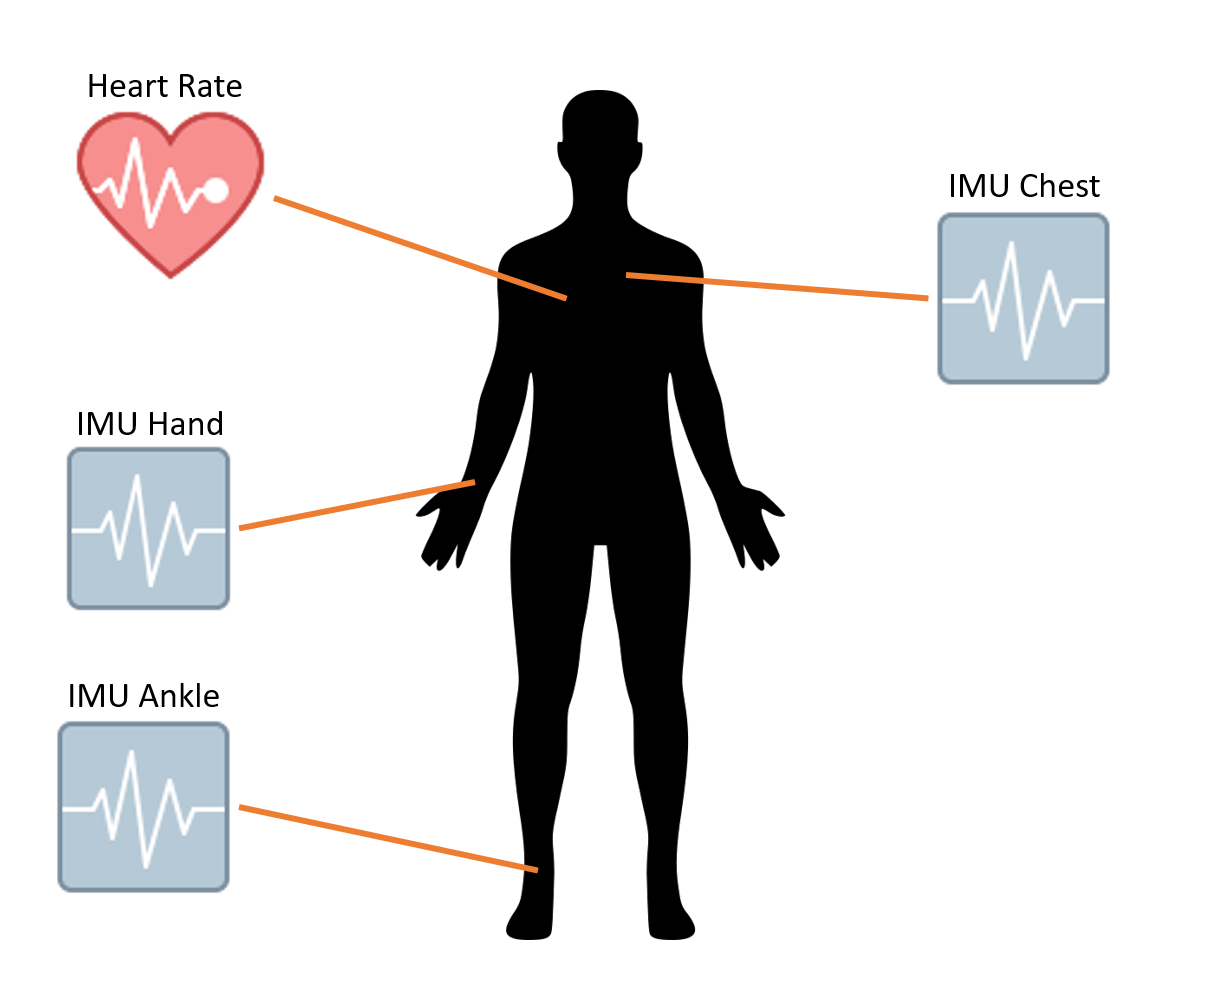

# Importing the data

In [8]:
#Libraries used in the report.

import numpy as np  
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import scipy.stats as stats #For the correlation matrix and calculation of the p-value
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import metrics

We create a dimension table with the information for each subject.

In [9]:
elementos= { 
"Subject_ID": [101,102,103,104,105,106,107,108,109],
"Sex":["Male","Female","Male","Male","Male","Male","Male","Male","Male"],
"Age (years)":[27,25, 31, 24,26,26,23,32,31],
"Height (cm)":[182,169,187,194,180,183,173,179,168],
"Weight (kg)":[83,78,92,95,73,69,86,87,65],
"Resting HR (bpm)":[75,74,68,58,70,60,60,66,54],
"Max HR (bpm)":[193,195,189,196,194,194,197,188,189],
"Dominant hand":["right","right","right","right","right","right","right","left","right"]
}

DimSubject=pd.DataFrame(elementos)

In [10]:
DimSubject

Subject_ID     Sex  Age (years)  Height (cm)  Weight (kg)  \
0         101    Male           27          182           83   
1         102  Female           25          169           78   
2         103    Male           31          187           92   
3         104    Male           24          194           95   
4         105    Male           26          180           73   
5         106    Male           26          183           69   
6         107    Male           23          173           86   
7         108    Male           32          179           87   
8         109    Male           31          168           65   

   Resting HR (bpm)  Max HR (bpm) Dominant hand  
0                75           193         right  
1                74           195         right  
2                68           189         right  
3                58           196         right  
4                70           194         right  
5                60           194         right  
6                60           197         right  
7                66           188          left  
8                54           189         right

We create a dimension table with the information of each activity. This table will allow us to add the name of the activity and the intensity (low, medium, high) to our main data table, making a crosswalk through the activityID.

In [11]:
elementos= { 
"activityID": [1,2,3,4,5,6,7,9,10,11,12,13,16,17,18,19,20,24,0],
"activity":["lying","sitting","standing","walking","running","cycling","Nordic walking","watching TV","computer work","car driving","ascending stairs","descending stairs","vacuum cleaning","ironing","folding laundry","house cleaning","playing soccer","rope jumping","other (transient activities)"],
"intensity":["low","low","low","medium","high","medium","medium","-","-","-","medium","medium","low","low","-","-","-","high","-"]   
}

DimActivity=pd.DataFrame(elementos)
                   


In [12]:
DimActivity

activityID                      activity intensity
0            1                         lying       low
1            2                       sitting       low
2            3                      standing       low
3            4                       walking    medium
4            5                       running      high
5            6                       cycling    medium
6            7                Nordic walking    medium
7            9                   watching TV         -
8           10                 computer work         -
9           11                   car driving         -
10          12              ascending stairs    medium
11          13             descending stairs    medium
12          16               vacuum cleaning       low
13          17                       ironing       low
14          18               folding laundry         -
15          19                house cleaning         -
16          20                playing soccer         -
17          24                  rope jumping      high
18           0  other (transient activities)         -

Next, we create our main table from the .dat files of each subject. The table is created from an iterative process (with a for) that runs through each document and stores it in a pandas dataframe.

In [13]:
import pandas as pd

files=['subject101','subject102','subject103','subject104','subject105','subject106','subject107','subject108','subject109']

colNames = ["timestamp", "activityID","heartrate"]

IMUhand = ['handTemperature', 
           'handAcc16_1', 'handAcc16_2', 'handAcc16_3', 
           'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 
           'handGyro1', 'handGyro2', 'handGyro3', 
           'handMagne1', 'handMagne2', 'handMagne3',
           'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4']

IMUchest = ['chestTemperature', 
           'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3', 
           'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3', 
           'chestGyro1', 'chestGyro2', 'chestGyro3', 
           'chestMagne1', 'chestMagne2', 'chestMagne3',
           'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4']

IMUankle = ['ankleTemperature', 
           'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3', 
           'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3', 
           'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 
           'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
           'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']

Additional_Columns=['Subject_ID']

columnsname = colNames + IMUhand + IMUchest + IMUankle + Additional_Columns #all columns in one list
 
for i in files:
    locals()["df"+"_"+str(i)] = pd.read_table(str(i)+".dat", 
                     header=None,
                     sep = "\s+",
                     #columns=columnsname
                    )
    locals()["df"+"_"+str(i)][54]=i[-3::]

In [14]:
frames=[df_subject101,df_subject102,df_subject103,df_subject104,df_subject105,df_subject106,df_subject107,df_subject108,df_subject109]

#this merges all the frames (for each subject) into a single frame
df_full = pd.concat(frames)

df_full.columns = columnsname

Here we perform an inner join between the main table and the activity dimension table, to add the activity and intentisy columns to our main table.

In [28]:
df_full=pd.merge(df_full,DimActivity, on='activityID', how='inner')

We display the table:

In [12]:
df_full.head()

timestamp  activityID  heartrate  handTemperature  handAcc16_1  \
0       8.38           0      104.0             30.0      2.37223   
1       8.39           0        NaN             30.0      2.18837   
2       8.40           0        NaN             30.0      2.37357   
3       8.41           0        NaN             30.0      2.07473   
4       8.42           0        NaN             30.0      2.22936   

   handAcc16_2  handAcc16_3  handAcc6_1  handAcc6_2  handAcc6_3  ...  \
0      8.60074      3.51048     2.43954     8.76165     3.35465  ...   
1      8.56560      3.66179     2.39494     8.55081     3.64207  ...   
2      8.60107      3.54898     2.30514     8.53644     3.73280  ...   
3      8.52853      3.66021     2.33528     8.53622     3.73277  ...   
4      8.83122      3.70000     2.23055     8.59741     3.76295  ...   

   ankleMagne1  ankleMagne2  ankleMagne3  ankleOrientation1  \
0     -61.1888     -38.9599     -58.1438                1.0   
1     -59.8479     -38.8919     -58.5253                1.0   
2     -60.7361     -39.4138     -58.3999                1.0   
3     -60.4091     -38.7635     -58.3956                1.0   
4     -61.5199     -39.3879     -58.2694                1.0   

   ankleOrientation2  ankleOrientation3  ankleOrientation4  Subject_ID  \
0                0.0                0.0                0.0         101   
1                0.0                0.0                0.0         101   
2                0.0                0.0                0.0         101   
3                0.0                0.0                0.0         101   
4                0.0                0.0                0.0         101   

                       activity  intensity  
0  other (transient activities)          -  
1  other (transient activities)          -  
2  other (transient activities)          -  
3  other (transient activities)          -  
4  other (transient activities)          -  

[5 rows x 57 columns]

# Data cleaning

We count the number of rows in each column and observe that for the most part, there is a good amount of data for each column, except for the heartrate column. This column contains too many null values and should be treated differently.

In [16]:
df_full.count()

timestamp            2872533
activityID           2872533
heartrate            2872533
handTemperature      2859392
handAcc16_1          2859392
handAcc16_2          2859392
handAcc16_3          2859392
handAcc6_1           2859392
handAcc6_2           2859392
handAcc6_3           2859392
handGyro1            2859392
handGyro2            2859392
handGyro3            2859392
handMagne1           2859392
handMagne2           2859392
handMagne3           2859392
handOrientation1     2859392
handOrientation2     2859392
handOrientation3     2859392
handOrientation4     2859392
chestTemperature     2868970
chestAcc16_1         2868970
chestAcc16_2         2868970
chestAcc16_3         2868970
chestAcc6_1          2868970
chestAcc6_2          2868970
chestAcc6_3          2868970
chestGyro1           2868970
chestGyro2           2868970
chestGyro3           2868970
chestMagne1          2868970
chestMagne2          2868970
chestMagne3          2868970
chestOrientation1    2868970
chestOrientati

We remove NaN values from all columns except heartrate, as the number of Nan values in heartrate is too high, so it must be treated differently.

In [17]:
## removal of any NaN values across the dataset
df_full= df_full.dropna(subset=["timestamp", "activityID",'handTemperature', 
           'handAcc16_1', 'handAcc16_2', 'handAcc16_3', 
           'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 
           'handGyro1', 'handGyro2', 'handGyro3', 
           'handMagne1', 'handMagne2', 'handMagne3',
           'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4','chestTemperature', 
           'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3', 
           'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3', 
           'chestGyro1', 'chestGyro2', 'chestGyro3', 
           'chestMagne1', 'chestMagne2', 'chestMagne3',
           'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4','ankleTemperature', 
           'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3', 
           'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3', 
           'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 
           'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
           'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4'])
df_full.reset_index(drop = True, inplace = True)

Para manejar los valores Nulos de HeartRate, tenemos dos opciones, simplemente eliminarlos o rellenar los valores vacios con un promedio. Elegimos esta última ya que si los eliminamos perdemos la mayor parte de la data.


In [15]:
df_full['heartrate']=df_full.heartrate.ffill(axis = 0)
#df_full['heartrate'] = df['BrandName'].replace(['ABC', 'AB'], 'A')

df_full_heartrate=df_full.dropna()
df_full_heartrate.reset_index(drop = True, inplace = True)

In [20]:
df_full.count()

timestamp            2844868
activityID           2844868
heartrate            2844868
handTemperature      2844868
handAcc16_1          2844868
handAcc16_2          2844868
handAcc16_3          2844868
handAcc6_1           2844868
handAcc6_2           2844868
handAcc6_3           2844868
handGyro1            2844868
handGyro2            2844868
handGyro3            2844868
handMagne1           2844868
handMagne2           2844868
handMagne3           2844868
handOrientation1     2844868
handOrientation2     2844868
handOrientation3     2844868
handOrientation4     2844868
chestTemperature     2844868
chestAcc16_1         2844868
chestAcc16_2         2844868
chestAcc16_3         2844868
chestAcc6_1          2844868
chestAcc6_2          2844868
chestAcc6_3          2844868
chestGyro1           2844868
chestGyro2           2844868
chestGyro3           2844868
chestMagne1          2844868
chestMagne2          2844868
chestMagne3          2844868
chestOrientation1    2844868
chestOrientati

In [21]:
#act_name=list(set(df_full['activityID'].values))
#datedd=df_full
#for act in act_name:
#    mean_num = np.mean(df_full[df_full['activityID']== act]['heartrate'])
#    datedd.loc[datedd['activityID']== act, ['heartrate']]=datedd.loc[datedd['activityID']== act, ['heartrate']].fillna(mean_num)

In [22]:
df_full = df_full[df_full.activityID != 0]

In [23]:
## checking if any null values exist in dataframe
df_full.isnull().sum()

timestamp            0
activityID           0
heartrate            0
handTemperature      0
handAcc16_1          0
handAcc16_2          0
handAcc16_3          0
handAcc6_1           0
handAcc6_2           0
handAcc6_3           0
handGyro1            0
handGyro2            0
handGyro3            0
handMagne1           0
handMagne2           0
handMagne3           0
handOrientation1     0
handOrientation2     0
handOrientation3     0
handOrientation4     0
chestTemperature     0
chestAcc16_1         0
chestAcc16_2         0
chestAcc16_3         0
chestAcc6_1          0
chestAcc6_2          0
chestAcc6_3          0
chestGyro1           0
chestGyro2           0
chestGyro3           0
chestMagne1          0
chestMagne2          0
chestMagne3          0
chestOrientation1    0
chestOrientation2    0
chestOrientation3    0
chestOrientation4    0
ankleTemperature     0
ankleAcc16_1         0
ankleAcc16_2         0
ankleAcc16_3         0
ankleAcc6_1          0
ankleAcc6_2          0
ankleAcc6_3

In [24]:
df_full_heartrate.head()

timestamp  activityID  heartrate  handTemperature  handAcc16_1  \
0       8.38           0      104.0             30.0      2.37223   
1       8.39           0      104.0             30.0      2.18837   
2       8.40           0      104.0             30.0      2.37357   
3       8.41           0      104.0             30.0      2.07473   
4       8.42           0      104.0             30.0      2.22936   

   handAcc16_2  handAcc16_3  handAcc6_1  handAcc6_2  handAcc6_3  ...  \
0      8.60074      3.51048     2.43954     8.76165     3.35465  ...   
1      8.56560      3.66179     2.39494     8.55081     3.64207  ...   
2      8.60107      3.54898     2.30514     8.53644     3.73280  ...   
3      8.52853      3.66021     2.33528     8.53622     3.73277  ...   
4      8.83122      3.70000     2.23055     8.59741     3.76295  ...   

   ankleGyro2  ankleGyro3  ankleMagne1  ankleMagne2  ankleMagne3  \
0    0.009250   -0.017580     -61.1888     -38.9599     -58.1438   
1   -0.004638    0.000368     -59.8479     -38.8919     -58.5253   
2    0.000148    0.022495     -60.7361     -39.4138     -58.3999   
3   -0.020301    0.011275     -60.4091     -38.7635     -58.3956   
4   -0.014303   -0.002823     -61.5199     -39.3879     -58.2694   

   ankleOrientation1  ankleOrientation2  ankleOrientation3  ankleOrientation4  \
0                1.0                0.0                0.0                0.0   
1                1.0                0.0                0.0                0.0   
2                1.0                0.0                0.0                0.0   
3                1.0                0.0                0.0                0.0   
4                1.0                0.0                0.0                0.0   

   Subject_ID  
0         101  
1         101  
2         101  
3         101  
4         101  

[5 rows x 55 columns]

# Exploratory Data Analysis


### Heart Rate

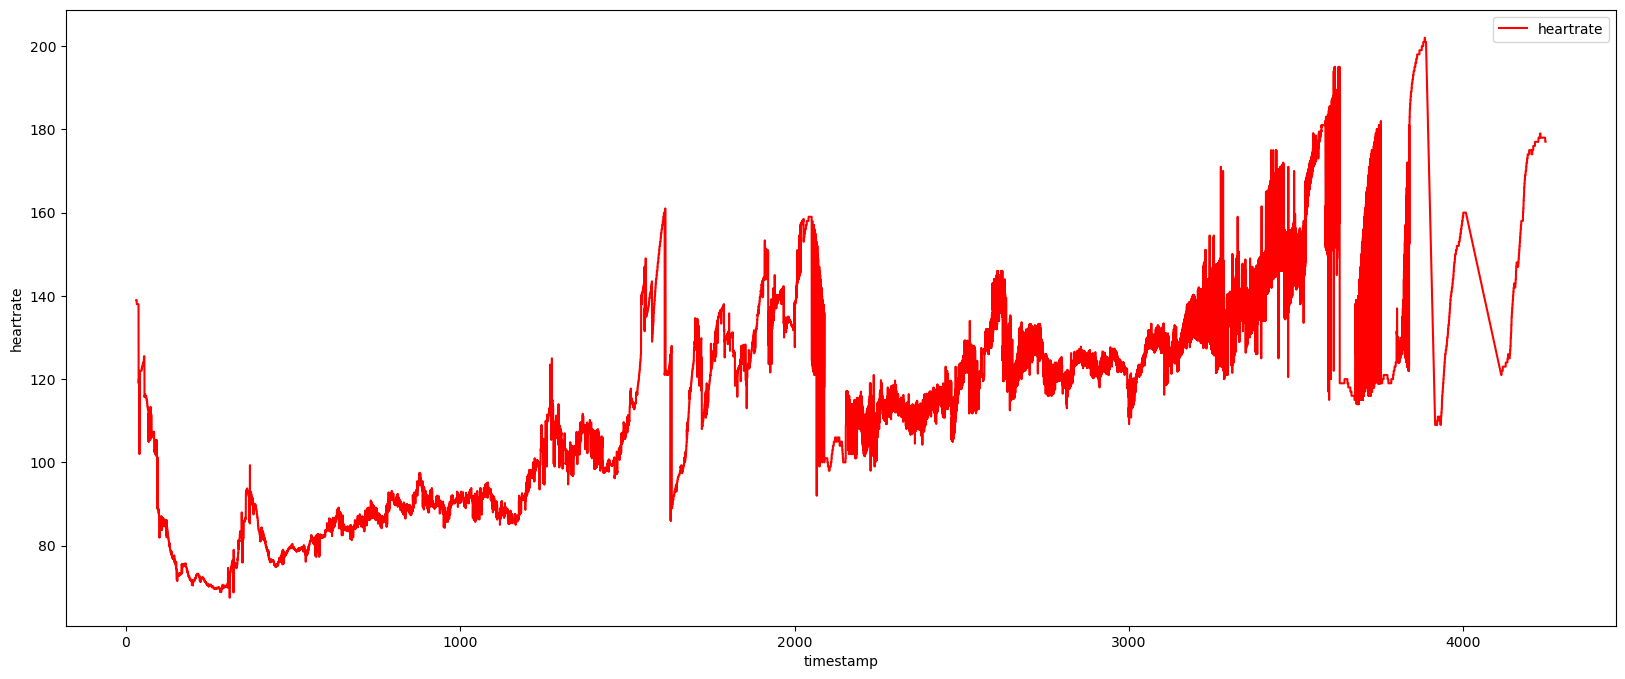

In [25]:
fig,axs = plt.subplots(ncols=1, figsize=(20,8))
sns.lineplot( x = "timestamp", y = "heartrate", data = df_full,ci=None,label='heartrate',color='red')

plt.show()

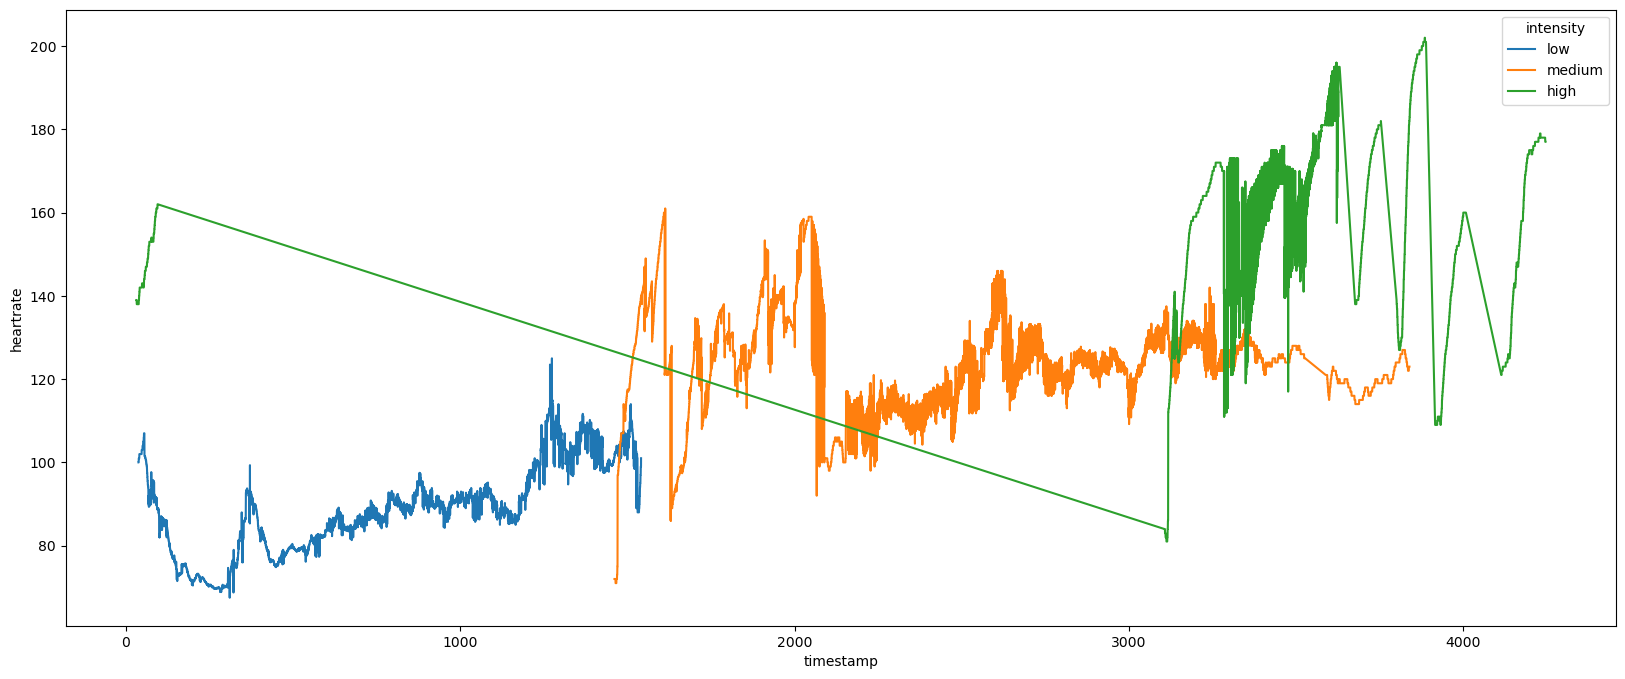

In [29]:
fig,axs = plt.subplots(ncols=1, figsize=(20,8))
sns.lineplot( x = "timestamp", y = "heartrate", data = df_full,ci=None,color='red',hue='intensity')

plt.show()

In [30]:
result = df_full.groupby(['timestamp','Subject_ID','activity']).aggregate({'heartrate':'max'})
result =result.groupby(['Subject_ID','activity']).aggregate({'heartrate':'mean'}).apply(lambda x: x.sort_values(ascending=True))
result2 =result.groupby(['activity']).aggregate({'heartrate':'mean'}).apply(lambda x: x.sort_values(ascending=True))
#print(result)

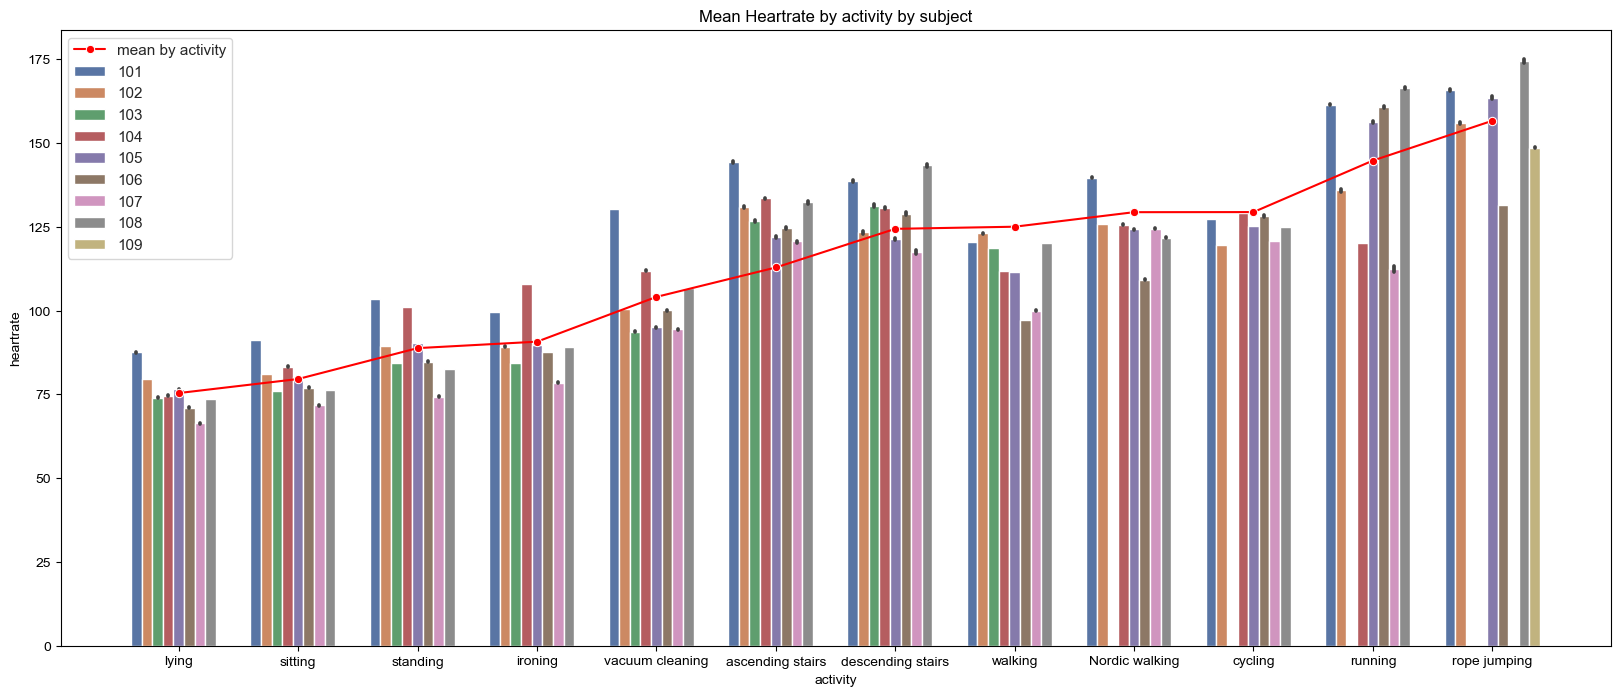

In [31]:
fig,axs = plt.subplots(ncols=1, figsize=(20,8))

sns.set_theme(style="whitegrid")
#custom_params = {"axes.spines.right": False, "axes.spines.top": False}
#sns.set_theme(style="ticks", rc=custom_params)
sns.barplot(data=df_full, x="activity", y="heartrate", hue="Subject_ID")
sns.lineplot( x = "activity", y = "heartrate", data = result2,ci=None,color='red',label='mean by activity',marker="o")
#sns.lineplot( x = "title_year", y = "budget", data = df_full,ci=None,label='budget',color='blue')
#sns.lineplot( x = "title_year", y = "gross", data = df_full,ci=None,label='gross',color='green')
plt.title("Mean Heartrate by activity by subject")
#fig.tight_layout()
plt.show()

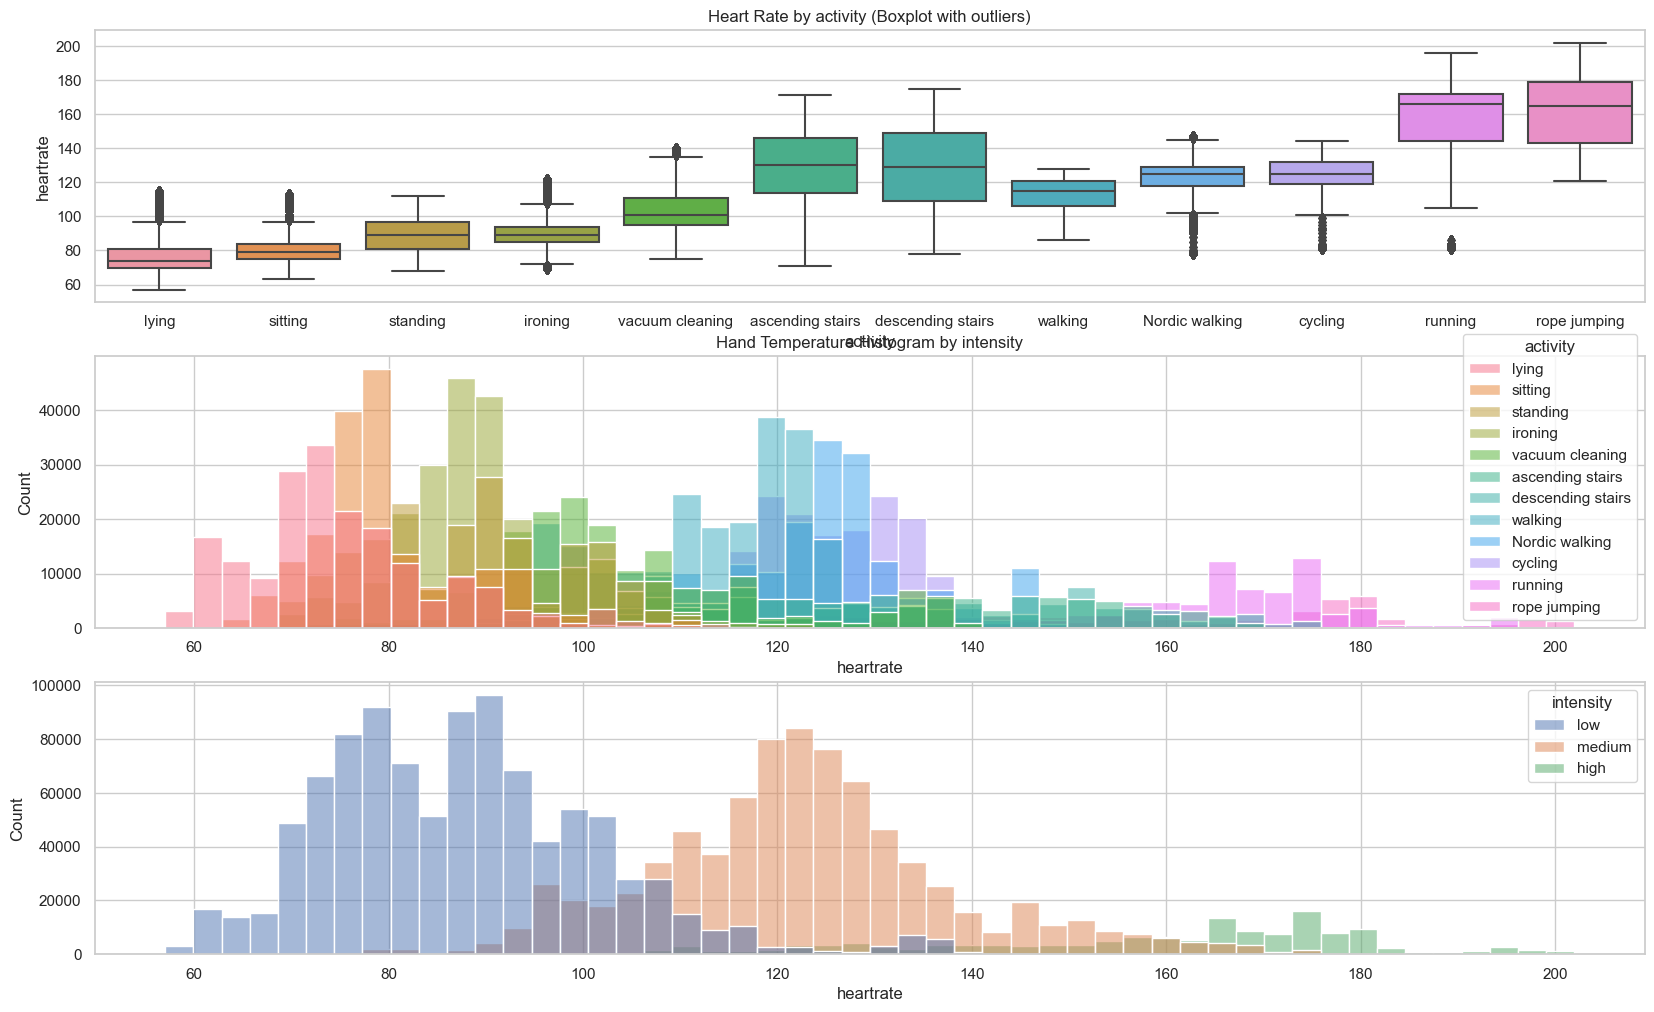

In [36]:
fig,axs = plt.subplots(nrows=3, figsize=(20,12))
sns.boxplot(x="activity", y="heartrate", data=df_full,showfliers=True,ax=axs[0])
sns.histplot(df_full, x="heartrate",bins=50,hue='activity',ax=axs[1]) 
sns.histplot(df_full, x="heartrate",bins=50,hue='intensity',ax=axs[2]) 
axs[0].set_title('Heart Rate by activity (Boxplot with outliers)')
axs[1].set_title('Hand Temperature Histogram by activity')    
axs[1].set_title('Hand Temperature Histogram by intensity')    
plt.show()

### Temperature

In [34]:
df1=df_full[['Subject_ID','handTemperature','activity']]
df1=df1.rename({'handTemperature': 'temperature'}, axis=1)
df1['bodyPart']='hand'

df2=df_full[['Subject_ID','chestTemperature','activity']]
df2=df2.rename({'chestTemperature': 'temperature'}, axis=1)
df2['bodyPart']='chest'

df3=df_full[['Subject_ID','ankleTemperature','activity']]
df3=df3.rename({'ankleTemperature': 'temperature'}, axis=1)
df3['bodyPart']='ankle'

concatTemperature = pd.concat([df1,df2,df3 ], ignore_index=True, sort=False)

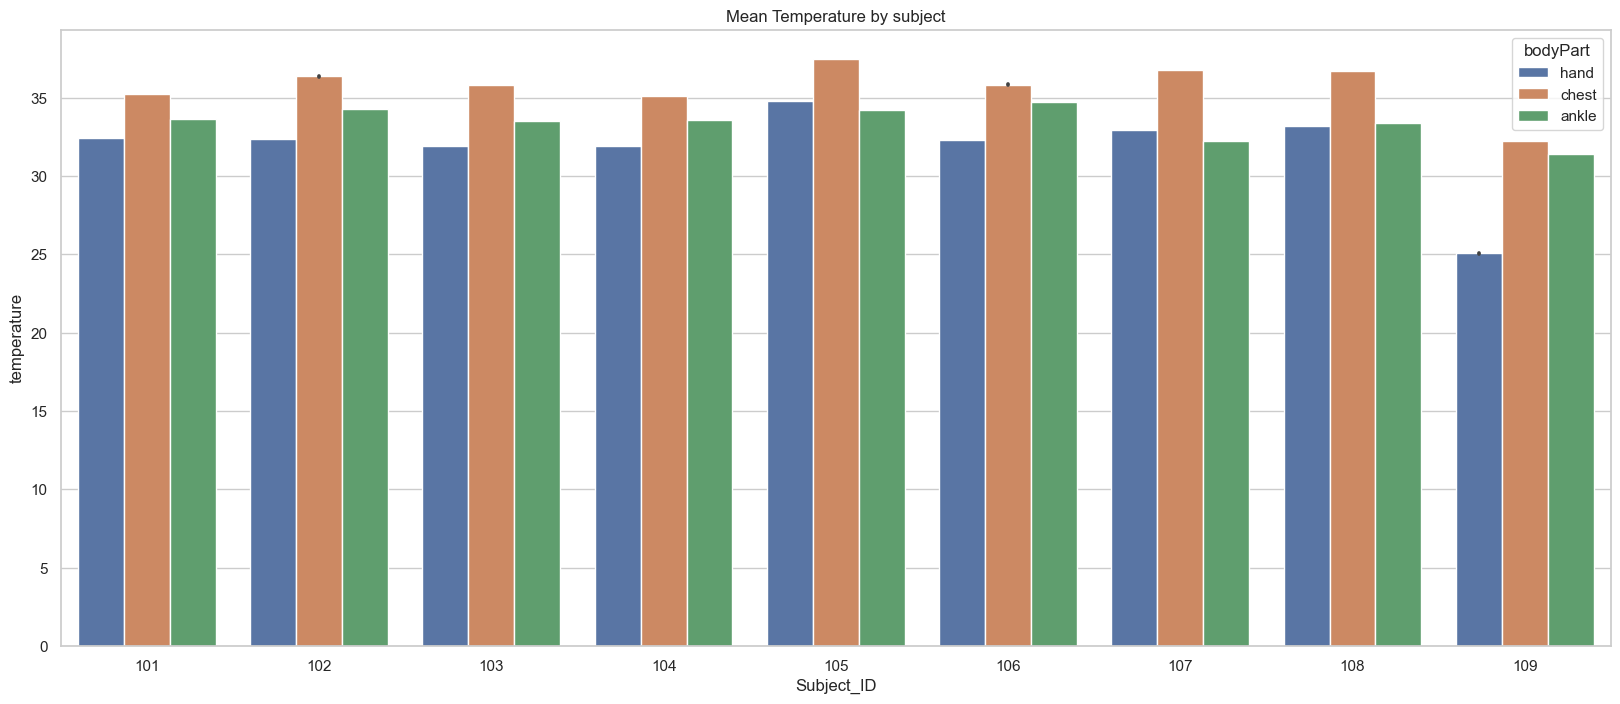

In [35]:
fig,axs = plt.subplots(ncols=1, figsize=(20,8))

sns.set_theme(style="whitegrid")
sns.barplot(x='Subject_ID', y="temperature", data=concatTemperature,hue='bodyPart')

plt.title("Mean Temperature by subject")
#fig.tight_layout()
plt.show()

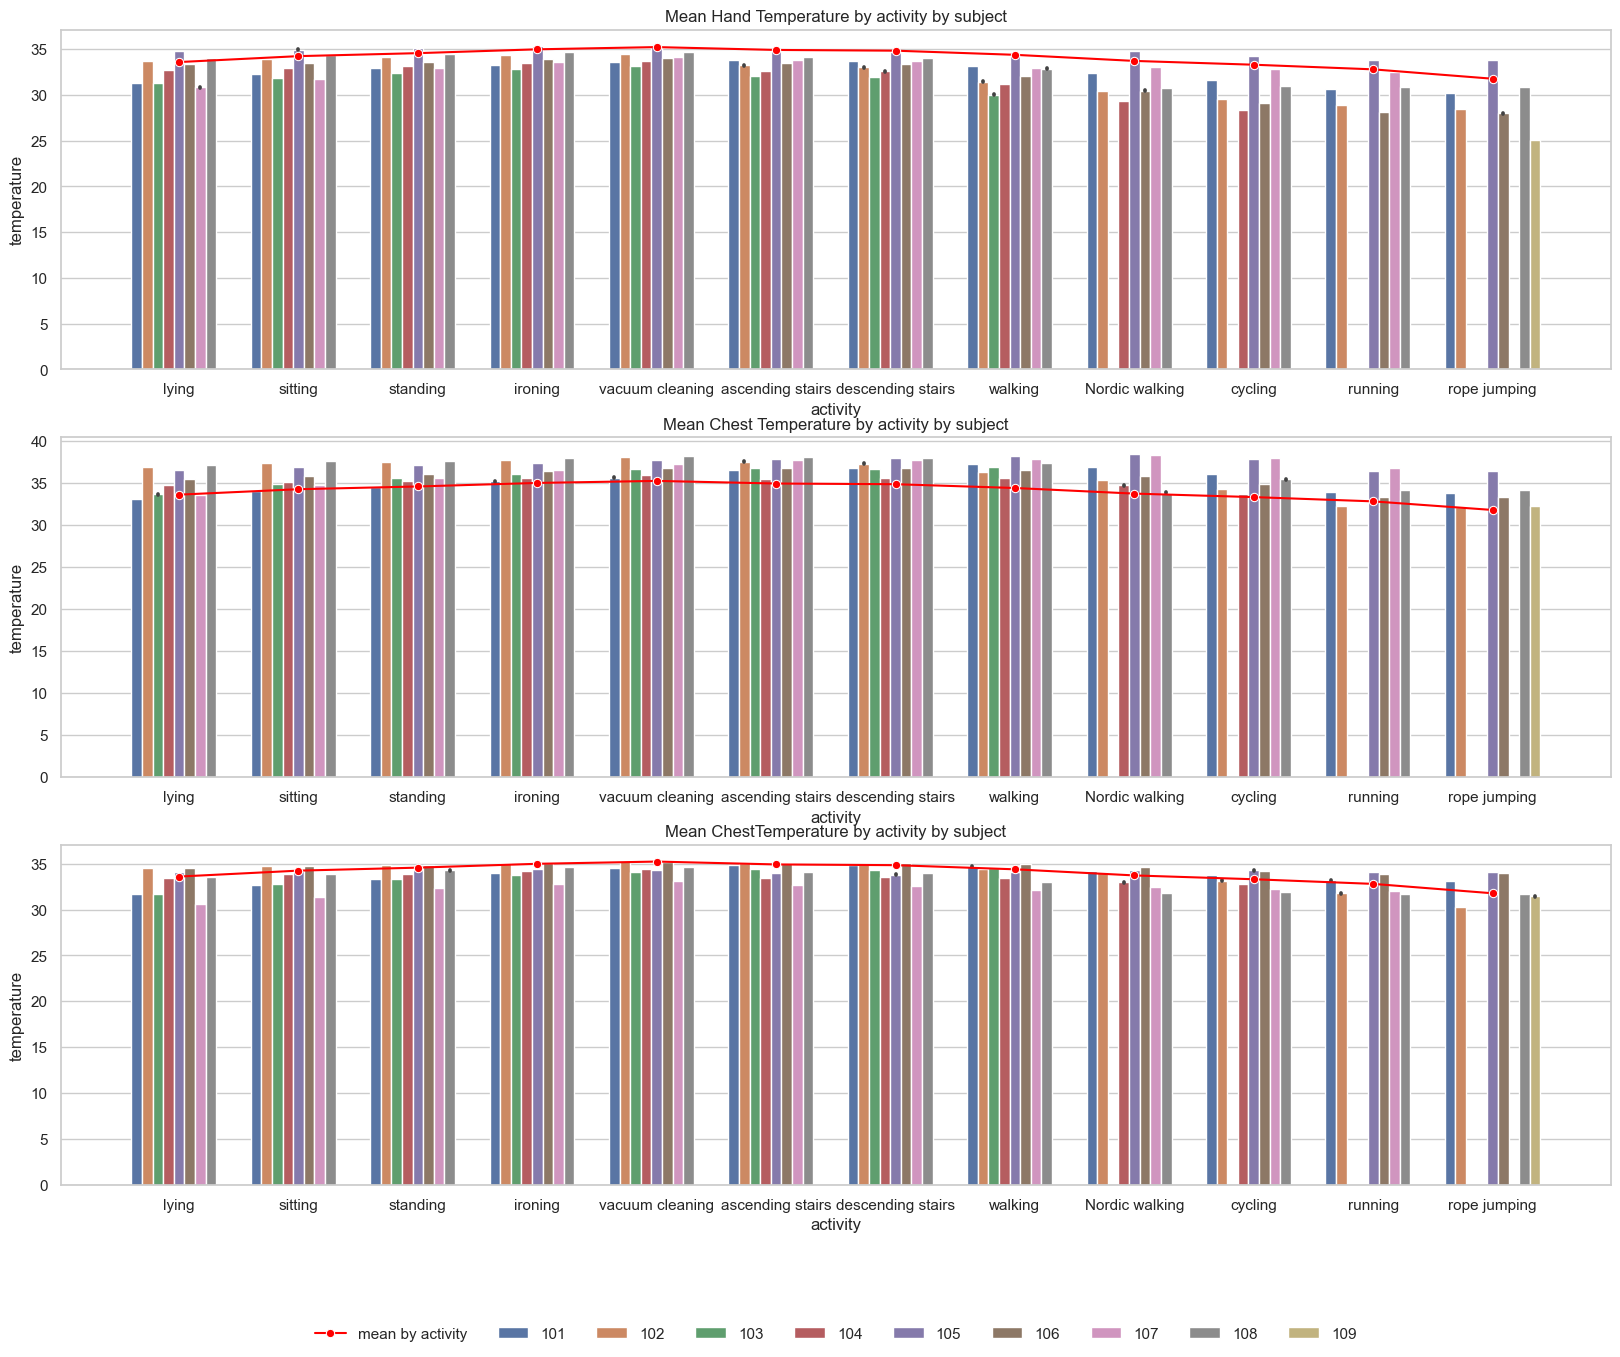

In [24]:
fig,axs = plt.subplots(nrows=3, figsize=(20,15))

#custom_params = {"axes.spines.right": False, "axes.spines.top": False}
#sns.set_theme(style="ticks", rc=custom_params)
sns.set_theme(style="whitegrid")

sns.barplot(x='activity', y="temperature", data=concatTemperature[(concatTemperature.bodyPart == "hand")],hue='Subject_ID',ax=axs[0])
sns.lineplot( x = "activity", y = "temperature", data = concatTemperature,ci=None,color='red',label='mean by activity',marker="o",ax=axs[0])
sns.move_legend(axs[0], "lower center",bbox_to_anchor=(.5, -0.5), ncol=10, title=None, frameon=False)

sns.barplot(x='activity', y="temperature", data=concatTemperature[(concatTemperature.bodyPart == "chest")],hue='Subject_ID',ax=axs[1])
sns.lineplot( x = "activity", y = "temperature", data = concatTemperature,ci=None,color='red',label='mean by activity',marker="o",ax=axs[1])
sns.move_legend(axs[1], "lower center", bbox_to_anchor=(.5, -0.5), ncol=10, title=None, frameon=False)

sns.barplot(x='activity', y="temperature", data=concatTemperature[(concatTemperature.bodyPart == "ankle")],hue='Subject_ID',ax=axs[2])
sns.lineplot( x = "activity", y = "temperature", data = concatTemperature,ci=None,color='red',label='mean by activity',marker="o",ax=axs[2])
sns.move_legend(axs[2], "lower center", bbox_to_anchor=(.5, -0.5), ncol=10, title=None, frameon=False)

#sns.move_legend(axs[2], "lower center",bbox_to_anchor=(.5, -0.5), ncol=3, title=None, frameon=False)
axs[0].set_title('Mean Hand Temperature by activity by subject')
axs[1].set_title('Mean Chest Temperature by activity by subject')           
axs[2].set_title('Mean ChestTemperature by activity by subject')  

#fig.tight_layout()
plt.show()

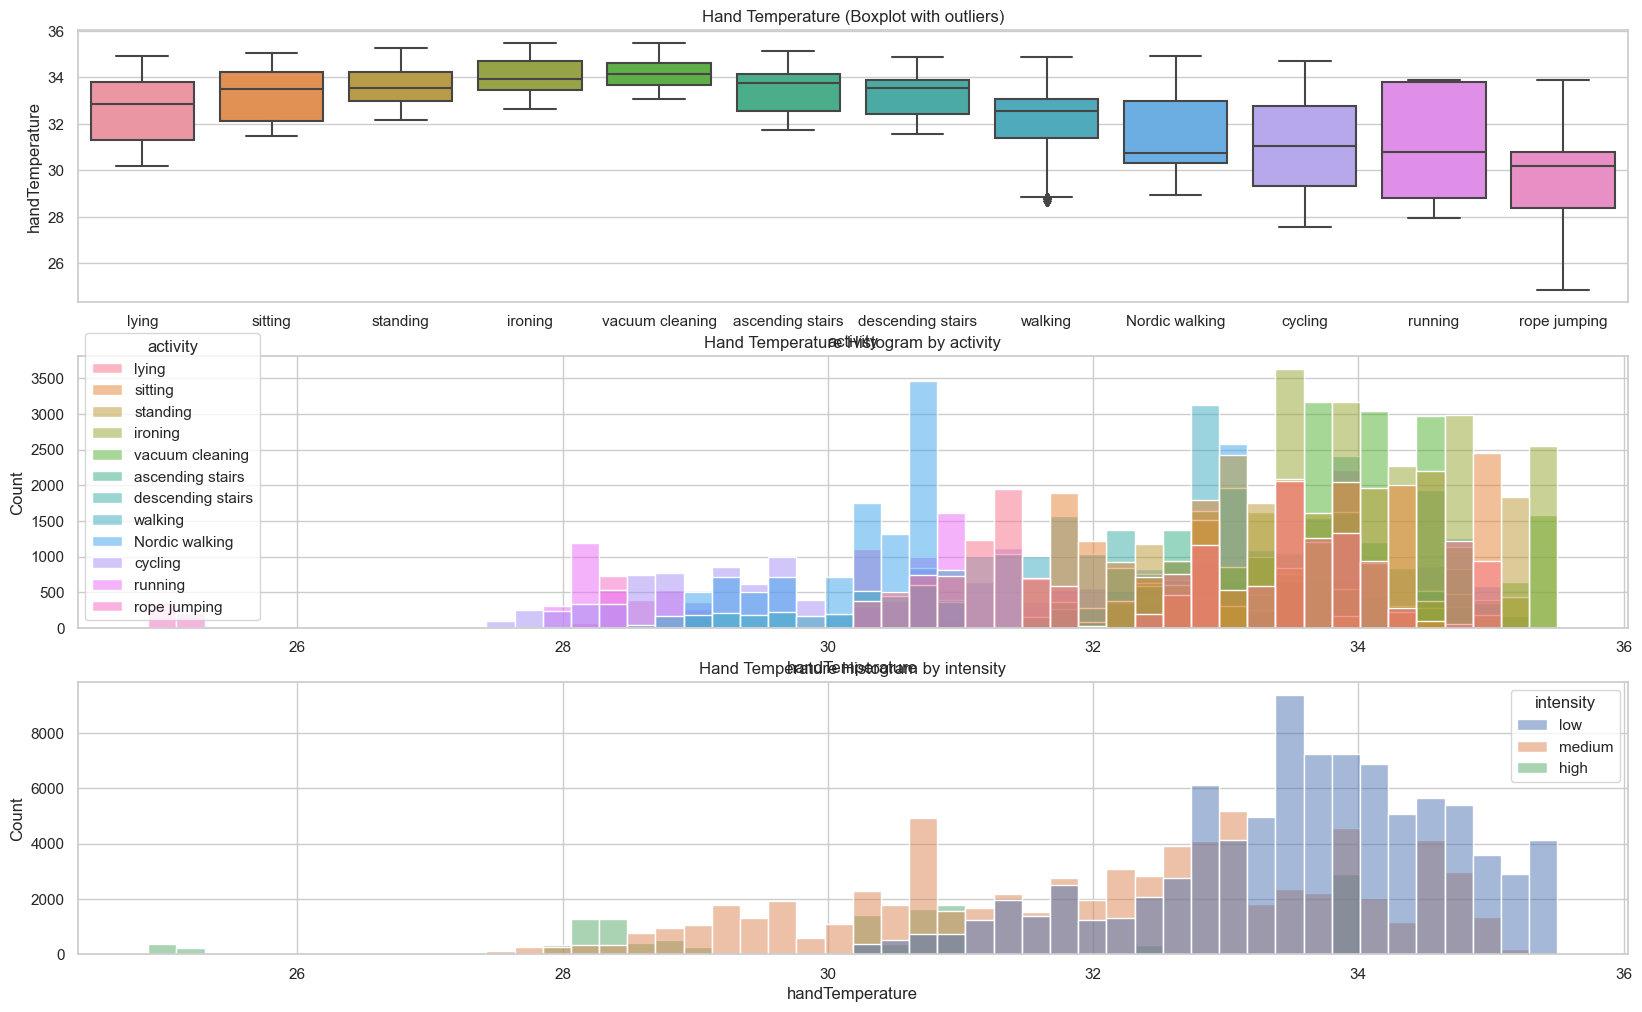

In [25]:
fig,axs = plt.subplots(nrows=3, figsize=(20,12))
sns.boxplot(x="activity", y="handTemperature", data=df_full,showfliers=True,ax=axs[0])
sns.histplot(df_full, x="handTemperature",bins=50,hue='activity',ax=axs[1]) 
sns.histplot(df_full, x="handTemperature",bins=50,hue='intensity',ax=axs[2]) 
axs[0].set_title('Hand Temperature (Boxplot with outliers)')
axs[1].set_title('Hand Temperature Histogram by activity')  
axs[2].set_title('Hand Temperature Histogram by intensity')  
plt.show()

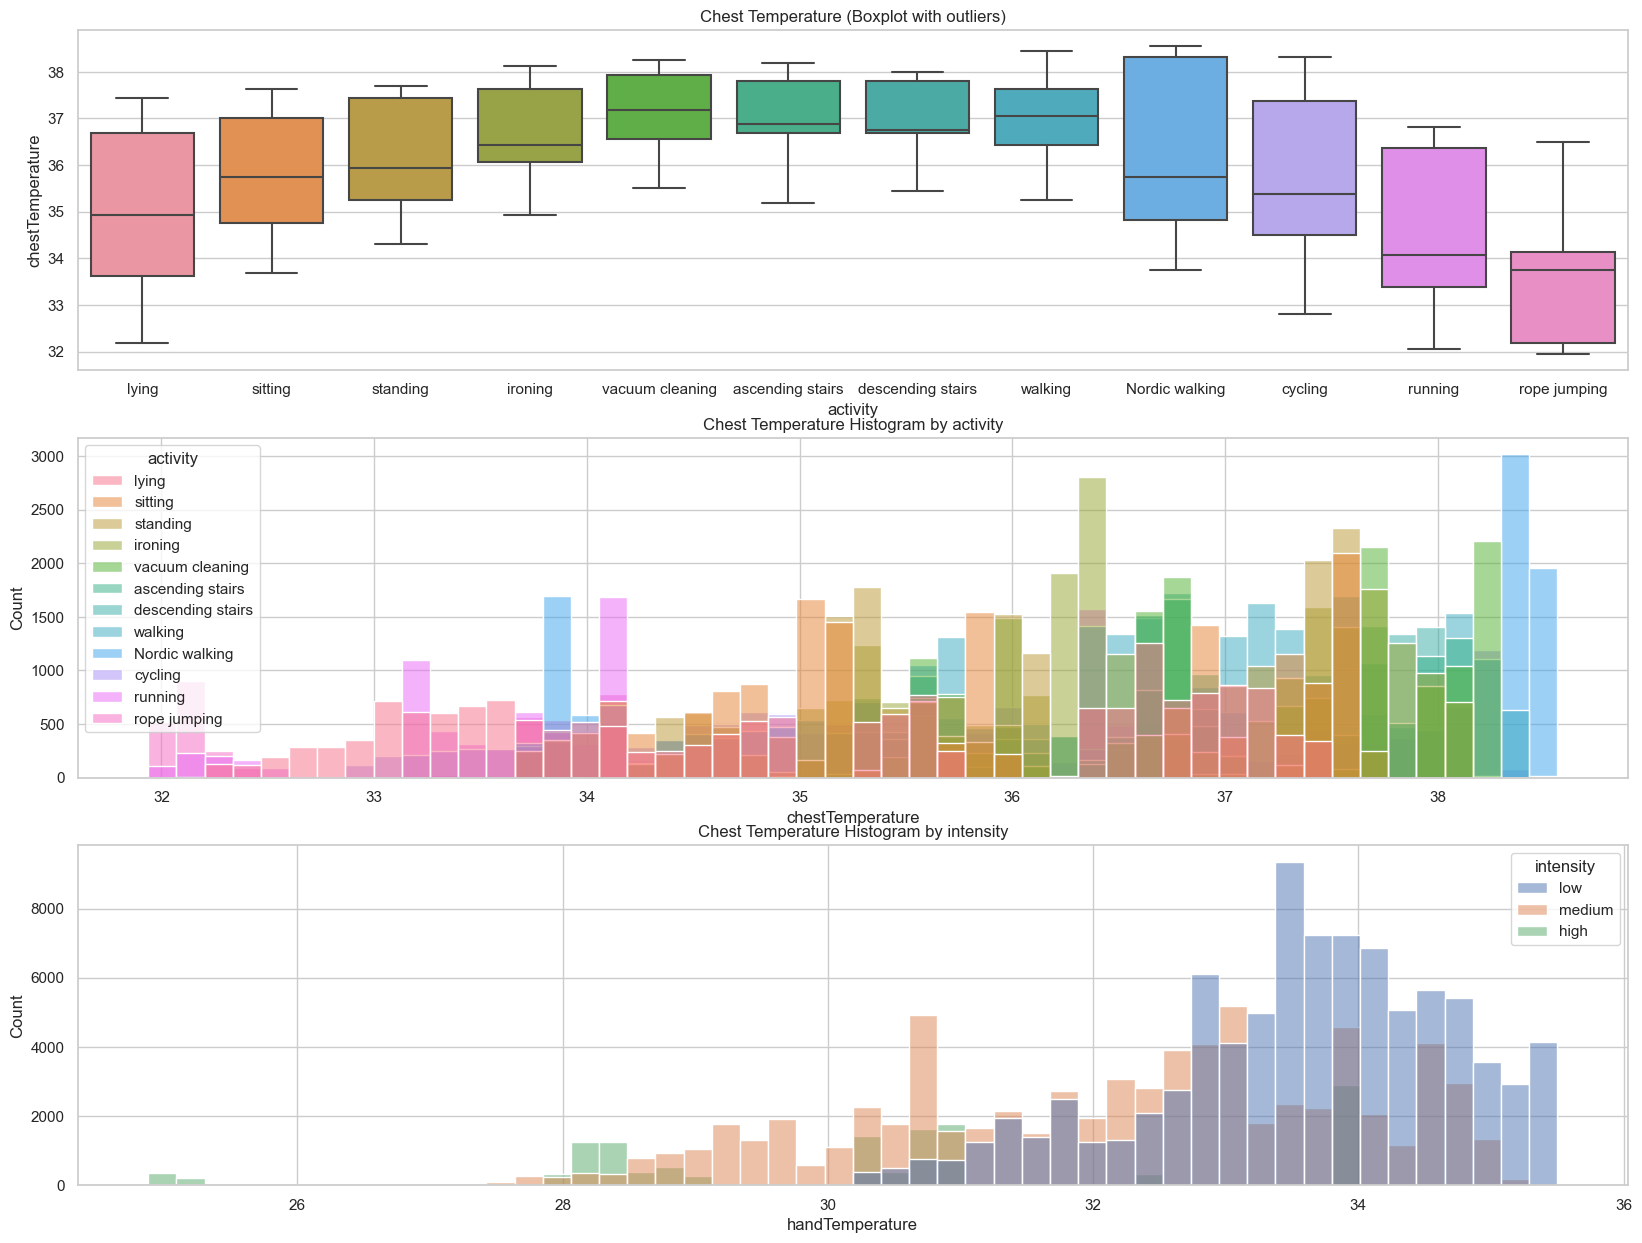

In [26]:
fig,axs = plt.subplots(nrows=3, figsize=(20,15))
sns.boxplot(x="activity", y="chestTemperature", data=df_full,showfliers=True,ax=axs[0])
sns.histplot(df_full, x="chestTemperature",bins=50,hue='activity',ax=axs[1])
sns.histplot(df_full, x="handTemperature",bins=50,hue='intensity',ax=axs[2]) 
axs[0].set_title('Chest Temperature (Boxplot with outliers)')
axs[1].set_title('Chest Temperature Histogram by activity')  
axs[2].set_title('Chest Temperature Histogram by intensity')                         
plt.show()

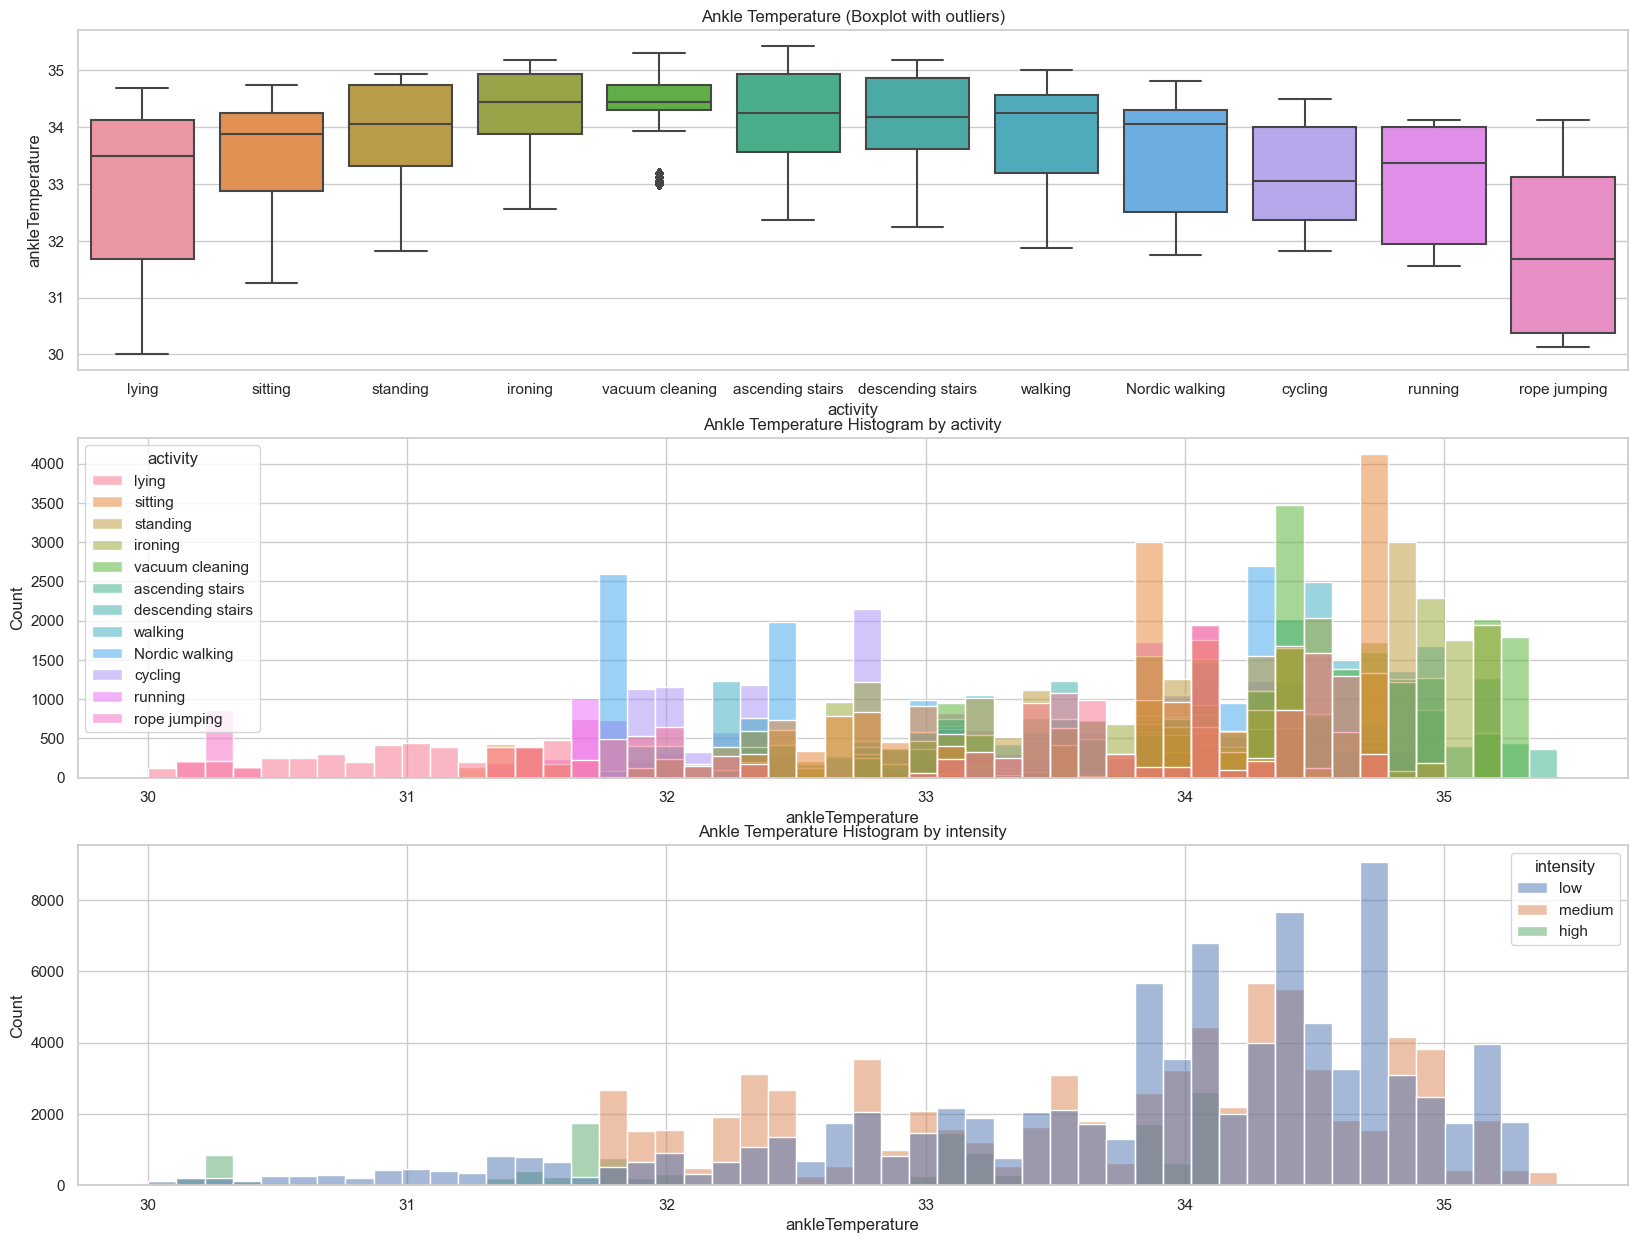

In [27]:
fig,axs = plt.subplots(nrows=3, figsize=(20,15))
sns.boxplot(x="activity", y="ankleTemperature", data=df_full,showfliers=True,ax=axs[0])
sns.histplot(df_full, x="ankleTemperature",bins=50,hue='activity',ax=axs[1]) 
sns.histplot(df_full, x="ankleTemperature",bins=50,hue='intensity',ax=axs[2]) 

axs[0].set_title('Ankle Temperature (Boxplot with outliers)')
axs[1].set_title('Ankle Temperature Histogram by activity')  
axs[2].set_title('Ankle Temperature Histogram by intensity')                              
plt.show()

In [28]:
concatTemperature

Subject_ID  temperature      activity bodyPart
0             101       30.375         lying     hand
1             101       30.375         lying     hand
2             101       30.375         lying     hand
3             101       30.375         lying     hand
4             101       30.375         lying     hand
...           ...          ...           ...      ...
526489        109       31.500  rope jumping    ankle
526490        109       31.500  rope jumping    ankle
526491        109       31.500  rope jumping    ankle
526492        109       31.500  rope jumping    ankle
526493        109       31.500  rope jumping    ankle

[526494 rows x 4 columns]

In [31]:
df_full

timestamp  activityID  heartrate  handTemperature  handAcc16_1  \
84305       37.70           1      100.0           30.375      2.30106   
84306       37.81           1      100.0           30.375      2.24615   
84307       37.92           1      100.0           30.375      2.30000   
84308       38.03           1      100.0           30.375      2.49455   
84309       38.14           1      101.0           30.375      2.71654   
...           ...         ...        ...              ...          ...   
259798      94.66          24      162.0           25.125      4.78601   
259799      94.77          24      162.0           25.125      4.34732   
259800      94.88          24      162.0           25.125      4.70704   
259801      94.98          24      162.0           25.125      4.81452   
259802      95.09          24      162.0           25.125      5.13914   

        handAcc16_2  handAcc16_3  handAcc6_1  handAcc6_2  handAcc6_3  ...  \
84305       7.25857      6.09259     2.20720     7.24042     5.95555  ...   
84306       7.48180      5.55219     2.25130     7.40595     5.65313  ...   
84307       7.10681      6.09309     2.34613     7.46611     6.12103  ...   
84308       7.52335      6.17157     2.59106     7.76653     6.27112  ...   
84309       8.30596      4.78671     2.59596     7.94641     4.86635  ...   
...             ...          ...         ...         ...         ...  ...   
259798      6.75444      7.05521     4.71052     6.72462     6.64876  ...   
259799      6.90337      6.35537     4.39582     6.96850     6.61834  ...   
259800      6.59291      5.89995     4.70308     6.48243     5.99996  ...   
259801      6.51482      5.74788     4.89736     6.49594     5.78832  ...   
259802      5.63724      5.48629     4.97690     5.69448     5.29167  ...   

        ankleMagne1  ankleMagne2  ankleMagne3  ankleOrientation1  \
84305      -60.2040   -37.122500   -57.884700           1.000000   
84306      -60.7820   -36.211600   -58.489100           1.000000   
84307      -61.4531   -36.298300   -58.484500           1.000000   
84308      -62.0065   -36.721700   -58.360800           1.000000   
84309      -60.4311   -37.541200   -59.001300           1.000000   
...             ...          ...          ...                ...   
259798     -46.0304    -1.464080    -0.453931           0.522578   
259799     -45.5269    -0.843791     0.114449           0.522768   
259800     -45.6476    -1.094840     0.256148           0.522624   
259801     -45.9167    -0.437698     0.254439           0.523382   
259802     -45.9093    -0.565555     0.680109           0.522536   

        ankleOrientation2  ankleOrientation3  ankleOrientation4  Subject_ID  \
84305            0.000000           0.000000           0.000000         101   
84306            0.000000           0.000000           0.000000         101   
84307            0.000000           0.000000           0.000000         101   
84308            0.000000           0.000000           0.000000         101   
84309            0.000000           0.000000           0.000000         101   
...                   ...                ...                ...         ...   
259798          -0.295758           0.700086          -0.386418         109   
259799          -0.293886           0.701447          -0.385119         109   
259800          -0.294082           0.703224          -0.381912         109   
259801          -0.292121           0.704582          -0.379869         109   
259802          -0.291955           0.706426          -0.377733         109   

            activity  intensity  
84305          lying        low  
84306          lying        low  
84307          lying        low  
84308          lying        low  
84309          lying        low  
...              ...        ...  
259798  rope jumping       high  
259799  rope jumping       high  
259800  rope jumping       high  
259801  rope jumping       high  
259802  rope jumping       high  

[175498 rows x 57 c

# Correlation matrix

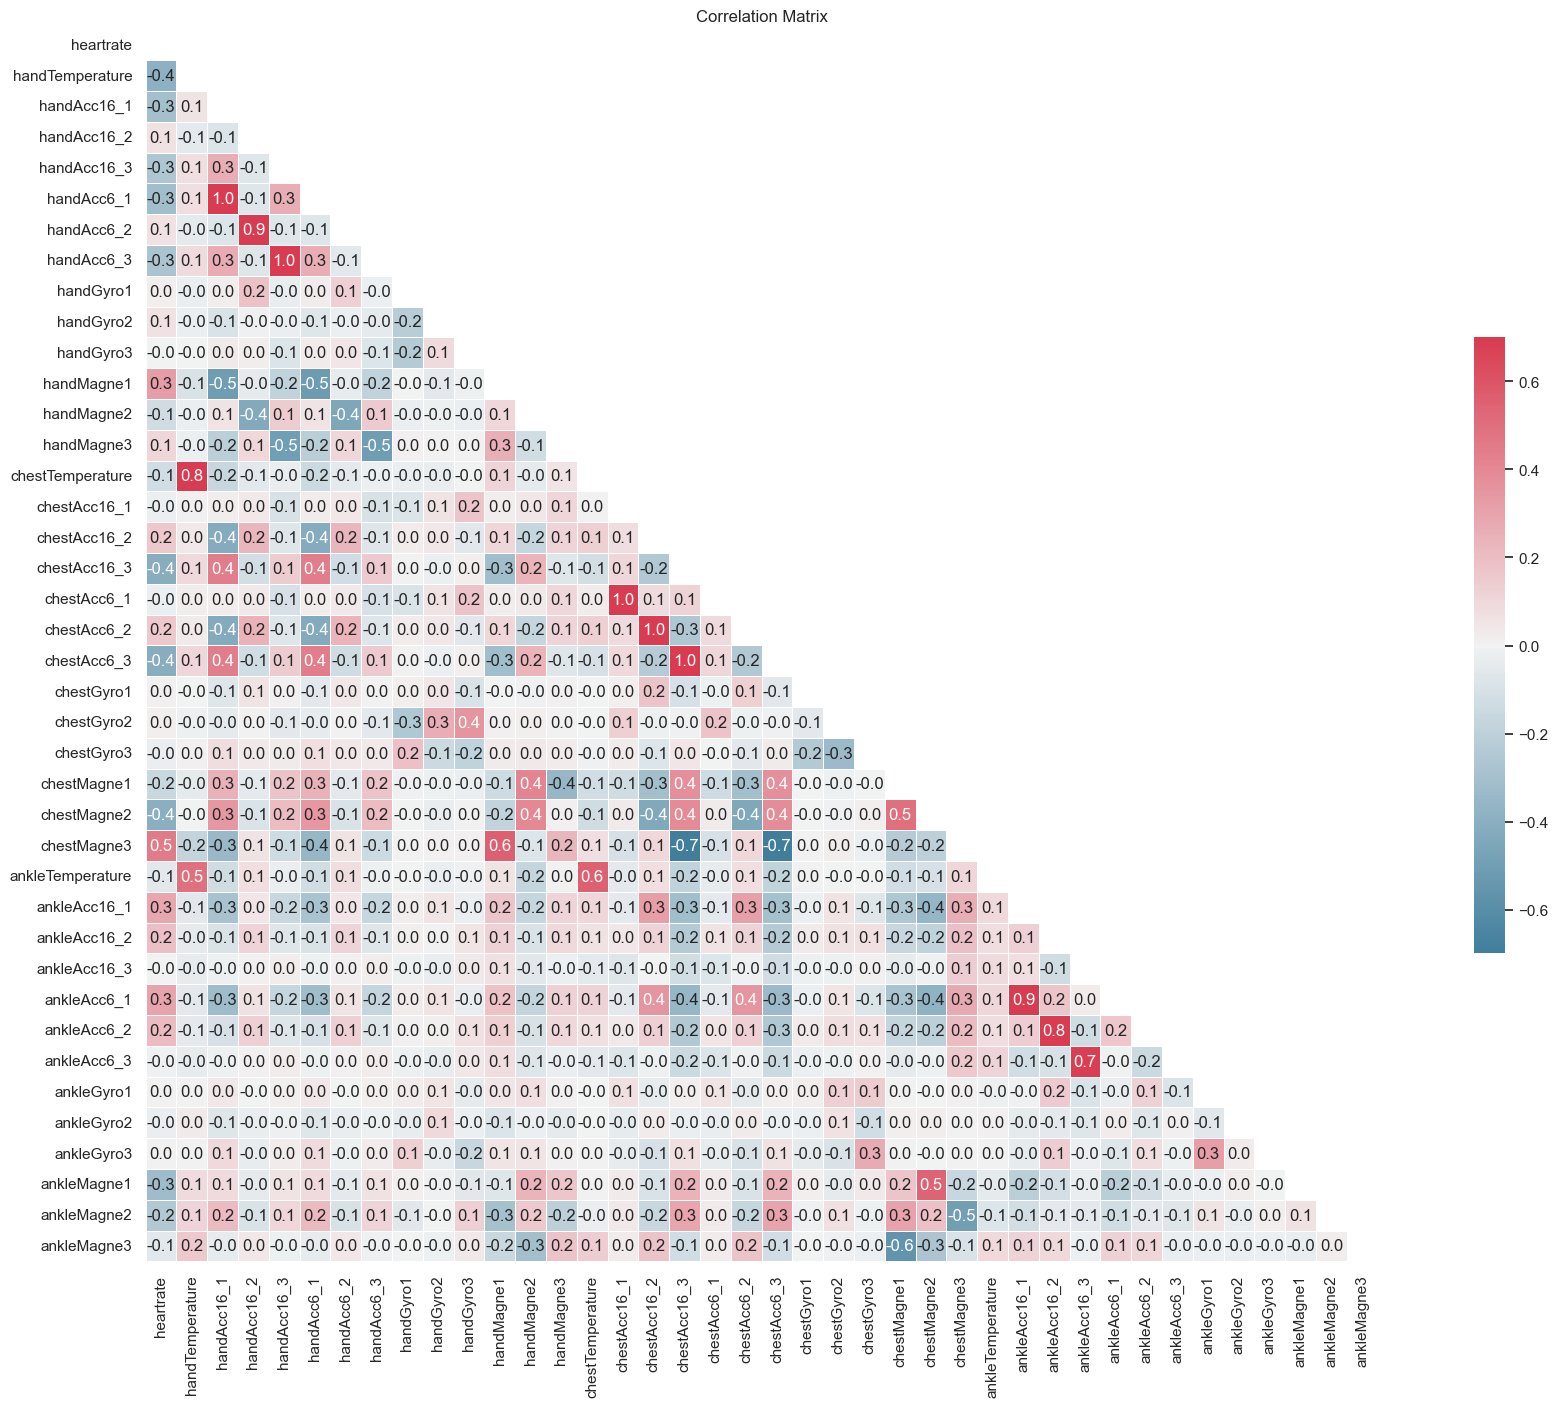

In [37]:
corr=df_full[['heartrate','handTemperature','handAcc16_1', 'handAcc16_2', 'handAcc16_3', 
                   'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 
           'handGyro1', 'handGyro2', 'handGyro3', 
           'handMagne1', 'handMagne2', 'handMagne3',
             'chestTemperature',
                   'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3', 
           'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3', 
           'chestGyro1', 'chestGyro2', 'chestGyro3', 
           'chestMagne1', 'chestMagne2', 'chestMagne3',
             'ankleTemperature', 
           'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3', 
           'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3', 
           'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 
           'ankleMagne1', 'ankleMagne2', 'ankleMagne3']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 16))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 8, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            annot = True, fmt='.1f')
#sns.set(font_scale=1.5)
plt.title("Correlation Matrix")
plt.show()

In [ ]:
 sns.pairplot(df_full, vars = ['heartrate','chestMagne3','handTemperature','chestMagne2','chestAcc16_3',
                               'chestAcc6_3'], hue='intensity')
plt.show()

In [ ]:
fig,axs = plt.subplots(ncols=1, figsize=(18,10))
sns.scatterplot( x = "chestMagne3", y = "heartrate", data = df_full,ci=None,color='red',hue='intensity')

plt.show()

# Model to predict Heart Rate

## Linear regresion model

In [31]:
# Regresión Lineal

X = df_full_heartrate[['chestMagne3','handTemperature','chestMagne2','chestAcc16_3','chestAcc6_3','ankleAcc6_1','ankleAcc6_2','ankleAcc6_3']]
#X = df_full[['chestMagne3']]
y = df_full_heartrate['heartrate']


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [33]:
# Regresión Lineal

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

In [34]:
print()
print("*** Coeficientes Linear Regression ***")
print(linreg.intercept_)
print(linreg.coef_)
print()
RMSE_linreg = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
print('Linear Regression (RMSE): ', RMSE_linreg)

print('Coefficient de correlacion PEARSON (LINREG):', linreg.score(X,y))


*** Coeficientes Linear Regression ***
244.53143007923745
[ 0.24928394 -4.73030406 -0.44482123  0.14036658 -0.61604734  0.29660073
  0.17462197 -0.42166857]

Linear Regression (RMSE):  20.948866160319355
Coefficient de correlacion PEARSON (LINREG): 0.3416433778560044


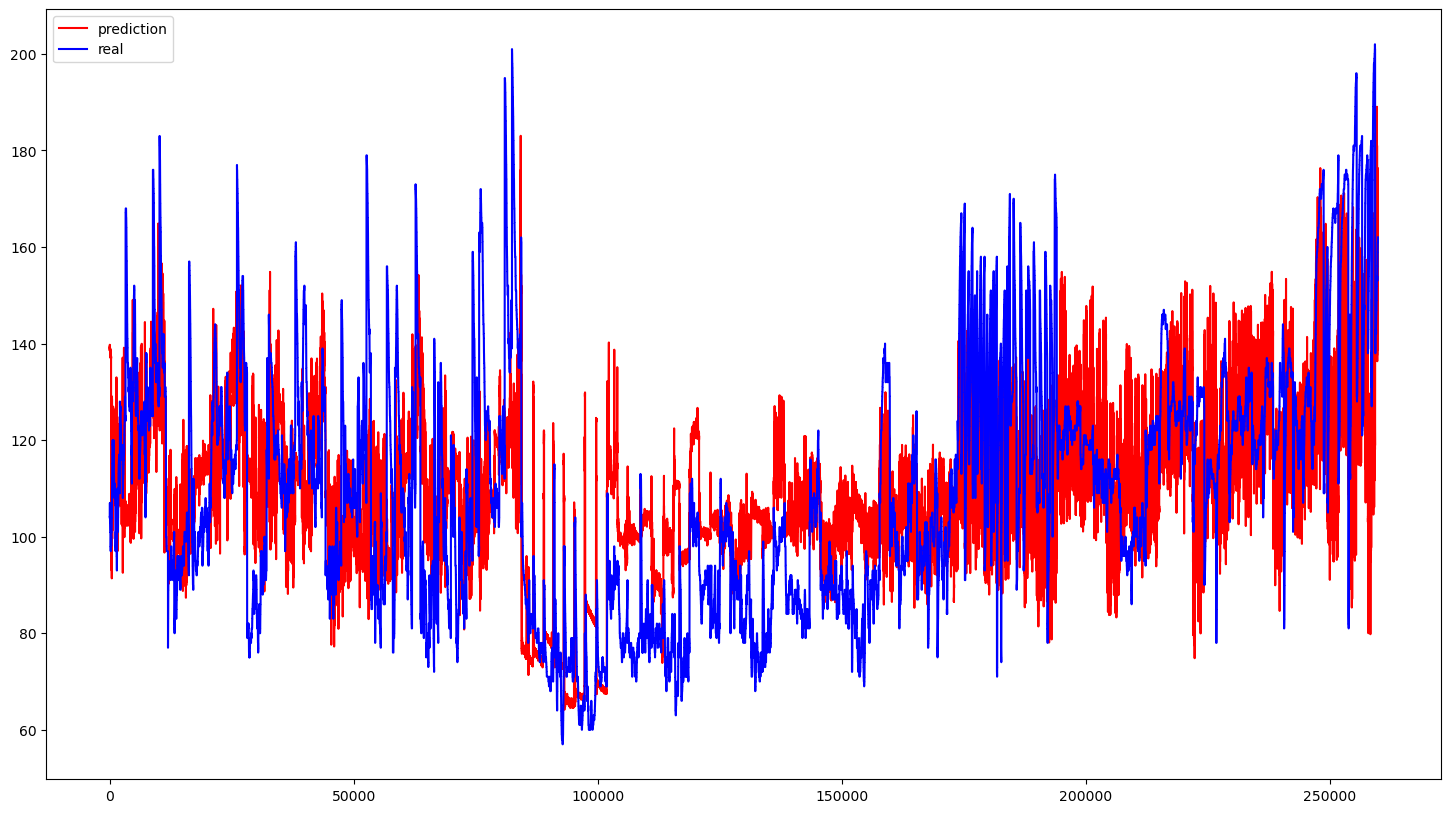

In [37]:
# Regresion Lineal

#y = df_full['heartrate']
yfit = linreg.predict(X)
#print(yfit[:30])
f, ax = plt.subplots(figsize=(18, 10))
plt.plot(yfit,label='prediction',color='red')
#plt.plot(y_test[:10000])
plt.plot(y,label='real',color='blue')
plt.legend()

## KFOLD

In [195]:
#Importamos la libreria KFold para implementar la validación cruzada
from sklearn.model_selection import KFold
kf=KFold(n_splits=5, random_state=None, shuffle=False)

##Ejemplo de como funciona kfold con un dataset de 5 datos
for train_index, test_index in kf.split([1,2,3,4,5]):
  print(train_index, test_index)

[1 2 3 4] [0]
[0 2 3 4] [1]
[0 1 3 4] [2]
[0 1 2 4] [3]
[0 1 2 3] [4]


In [35]:
#Definimos las metricas a medir del modelo

def get_score(model, X_train, X_test, y_train, y_test):
  model.fit(X_train,y_train)
  y_fit=model.predict(X_test)
  return metrics.r2_score(y_test,y_fit)
  

def get_varscore(model, X_train, X_test, y_train, y_test):
  model.fit(X_train,y_train)
  y_fit=model.predict(X_test)
  return metrics.explained_variance_score(y_test, y_fit)

In [36]:
#Acá entrenamos cada modelo con los diferentes splits del kfold (5 folds)

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from numpy import mean
from numpy import std


RMSE = []
Pearson = []
kf = KFold(n_splits=5,shuffle=True)
linreg = LinearRegression()

for k,(train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    linreg.fit(X_train, y_train)
    RMSE.append(np.sqrt(metrics.mean_squared_error(y_test, linreg.predict(X_test))))
    Pearson.append(linreg.score(X,y))
print(RMSE)
print('RMSE: %.3f (%.3f)' % (mean(RMSE), std(RMSE)))
print(Pearson)
print('Pearson Coefficient: %.3f (%.3f)' % (mean(Pearson), std(Pearson)))

#print('Coefficient de correlacion PEARSON (LINREG):', linreg.score(X,y))
#RMSE_linreg = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
#print('Linear Regression (RMSE): ', RMSE_linreg)

[21.0031534975804, 20.962202457912365, 20.898644013319817, 21.016348052703492, 20.99180935629283]
RMSE: 20.974 (0.042)
[0.3416595646216184, 0.34166200517994993, 0.3416605620089104, 0.34164833758493307, 0.3416506453094198]
Pearson Coefficient: 0.342 (0.000)


## Random forests (decision trees) model

In [198]:
features = pd.get_dummies(df_full)

In [199]:
features

timestamp  activityID  heartrate  handTemperature  handAcc16_1  \
0           37.70           1      100.0           30.375      2.30106   
1           37.81           1      100.0           30.375      2.24615   
2           37.92           1      100.0           30.375      2.30000   
3           38.03           1      100.0           30.375      2.49455   
4           38.14           1      101.0           30.375      2.71654   
...           ...         ...        ...              ...          ...   
175493      94.66          24      162.0           25.125      4.78601   
175494      94.77          24      162.0           25.125      4.34732   
175495      94.88          24      162.0           25.125      4.70704   
175496      94.98          24      162.0           25.125      4.81452   
175497      95.09          24      162.0           25.125      5.13914   

        handAcc16_2  handAcc16_3  handAcc6_1  handAcc6_2  handAcc6_3  ...  \
0           7.25857      6.09259     2.20720     7.24042     5.95555  ...   
1           7.48180      5.55219     2.25130     7.40595     5.65313  ...   
2           7.10681      6.09309     2.34613     7.46611     6.12103  ...   
3           7.52335      6.17157     2.59106     7.76653     6.27112  ...   
4           8.30596      4.78671     2.59596     7.94641     4.86635  ...   
...             ...          ...         ...         ...         ...  ...   
175493      6.75444      7.05521     4.71052     6.72462     6.64876  ...   
175494      6.90337      6.35537     4.39582     6.96850     6.61834  ...   
175495      6.59291      5.89995     4.70308     6.48243     5.99996  ...   
175496      6.51482      5.74788     4.89736     6.49594     5.78832  ...   
175497      5.63724      5.48629     4.97690     5.69448     5.29167  ...   

        activity_cycling  activity_descending stairs  activity_ironing  \
0                      0                           0                 0   
1                      0                           0                 0   
2                      0                           0                 0   
3                      0                           0                 0   
4                      0                           0                 0   
...                  ...                         ...               ...   
175493                 0                           0                 0   
175494                 0                           0                 0   
175495                 0                           0                 0   
175496                 0                           0                 0   
175497                 0                           0                 0   

        activity_lying  activity_rope jumping  activity_running  \
0                    1                      0                 0   
1                    1                      0                 0   
2                    1                      0                 0   
3                    1                      0                 0   
4                    1                      0                 0   
...                ...                    ...               ...   
175493               0                      1                 0   
175494               0                      1                 0   
175495               0                      1                 0   
175496               0                      1                 0   
175497               0                      1                 0   

        activity_sitting  activity_standing  activity_vacuum cleaning  \
0                      0                  0                         0   
1                      0                  0                         0   
2                      0                  0                         0   
3                      0                  0                         0   
4                      0                  0                         0   
...                  ...                ...                   

In [200]:
# Variable que queremos predecir. 
labels = np.array(features['heartrate'])

#Eliminar la variable a predecir del dataset original (axis 1 indica que es una columna).
features= features.drop('heartrate', axis = 1)
#features= features.drop('timestamp', axis = 1)
#features= features.drop('activityID', axis = 1)
#Guardar como una lista las variables independientes. 
feature_list = list(features.columns)

#Convertir las caracteristicas a NP array
features = np.array(features)


In [201]:
# Genere un conjunto de entrenamiento y validación. 
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25,
                                                                           random_state = 42)

In [202]:
print('Dimensiones de la data del conjunto de entrenamiento:', train_features.shape)
print('Dimensiones de las Etiquetas de la data del conjunto de entrenamiento:', train_labels.shape)
print('Dimensiones de la data del conjunto de prueba:', test_features.shape)
print('Dimensiones de las Etiquetas de la data del conjunto de prueba:', test_labels.shape)

Dimensiones de la data del conjunto de entrenamiento: (131623, 74)
Dimensiones de las Etiquetas de la data del conjunto de entrenamiento: (131623,)
Dimensiones de la data del conjunto de prueba: (43875, 74)
Dimensiones de las Etiquetas de la data del conjunto de prueba: (43875,)


In [203]:
from sklearn.ensemble import RandomForestRegressor

#Generar una instancia del modelo RandomForestRegressor
rf =RandomForestRegressor(n_estimators=10, max_depth = 3, random_state=42)

#Entrenar el modelo con el conjunto de pruebas
rf.fit(train_features, train_labels);

In [204]:
#Hacer predicciones con los datos de prueba
predictions = rf.predict(test_features)
#Calcular las diferencias en terminos absolutos
errors = abs(predictions - test_labels)
#Entregar el Error Absoluto Medio (mae)
print('Error Absoluto Medio (mae):', round(np.mean(errors), 2), 'grados')

Error Absoluto Medio (mae): 10.3 grados


In [205]:
# Determine el rendimiento del modelo.
mape = 100 * (errors / test_labels)

# Calculate la precision
accuracy = 100 - np.mean(mape)
print('Precision (Accuracy):', round(accuracy, 2), '%.')

Precision (Accuracy): 90.49 %.


In [263]:
timestamp_real = features[:, feature_list.index('timestamp')]
dates = [timestamp for timestamp in zip(timestamp_real)]

#Dataframe con los datos registrados y sus fechas
true_data = pd.DataFrame(data = {'time': timestamp_real, 'real': labels})

#Extraer por separado year, month, day del conjunto de Entrenamiento
timestamp_test = test_features[:, feature_list.index('timestamp')]

#Dataframe con los datos predecidos y sus fechas
predictions_data = pd.DataFrame(data = {'time': timestamp_test, 'prediction': predictions})


<AxesSubplot:xlabel='timestamp', ylabel='heartrate'>

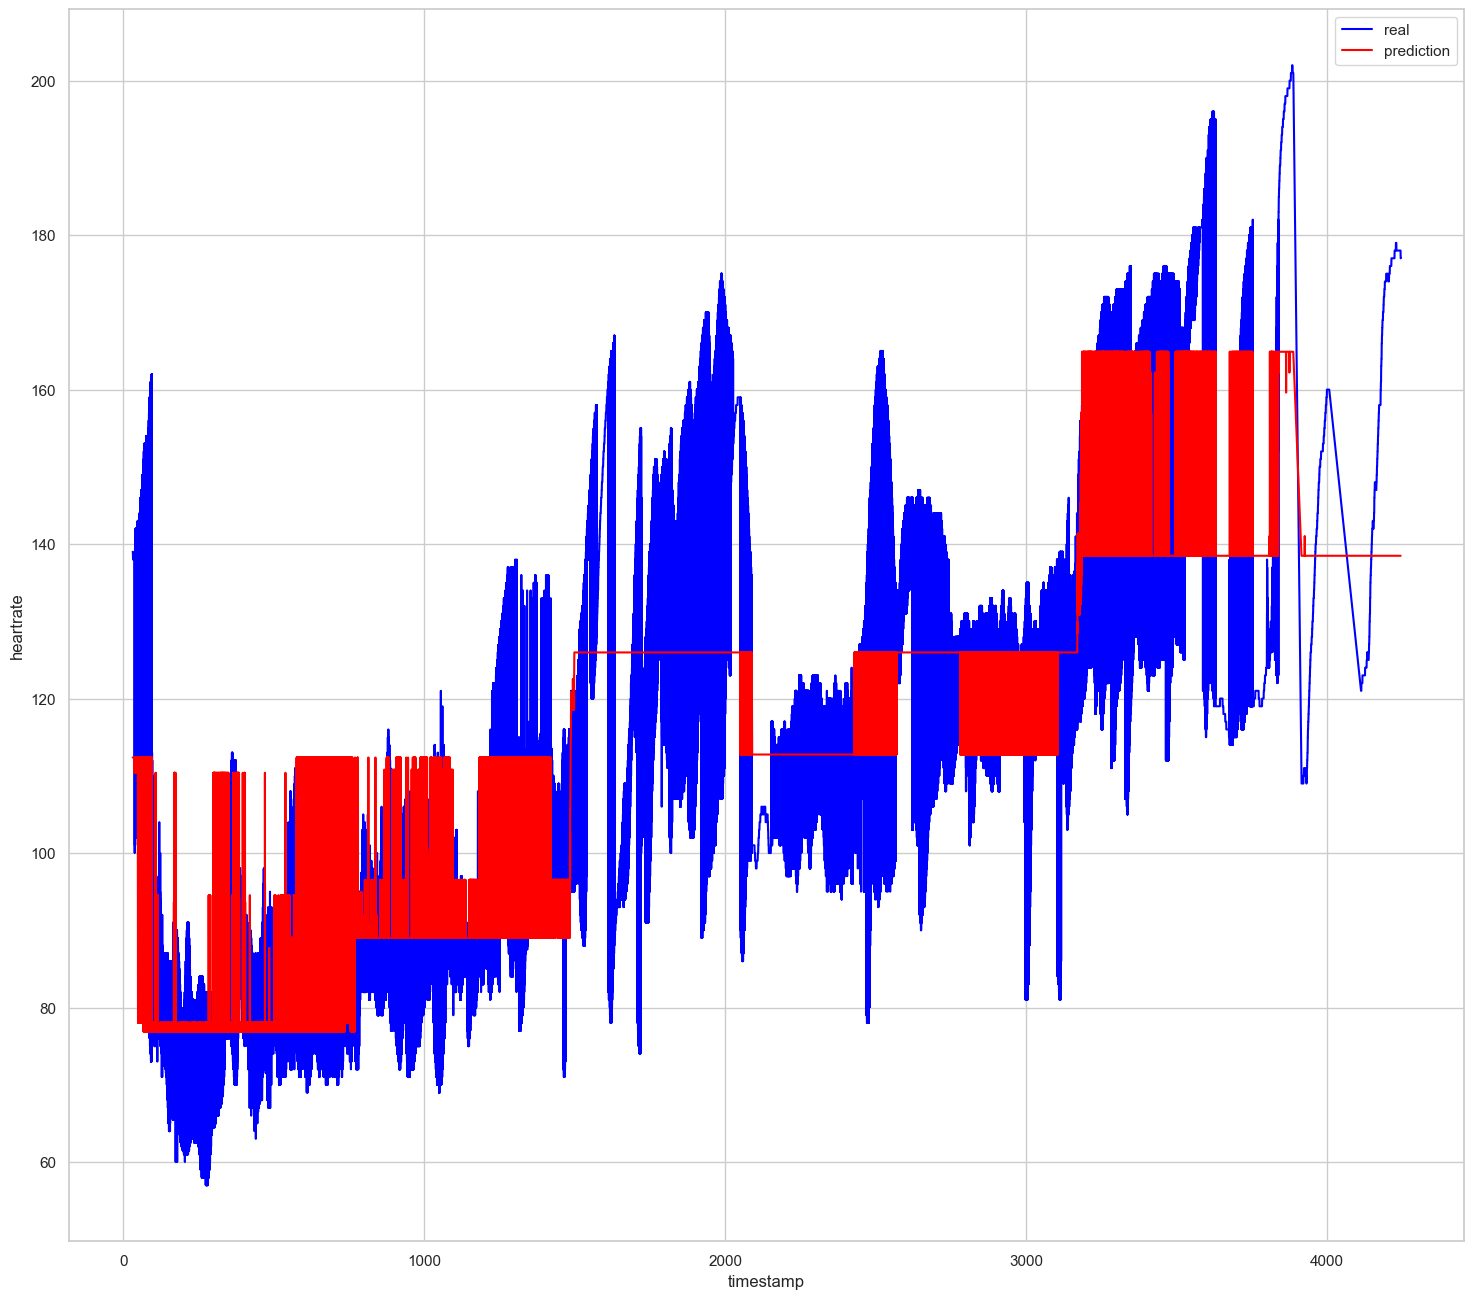

In [264]:
#Graficar los valores registrados
f, ax = plt.subplots(figsize=(18, 16))
sns.lineplot( x = "timestamp", y = "heartrate", data = df_full,ci=None,label='real',color='blue')

#Graficar los valores predecidos
sns.lineplot( x = "time", y = "prediction", data = predictions_data,ci=None,label='prediction',color='red')

#Etiquetas del grafico
#plt.xlabel('Periodo'); plt.ylabel('Temperatura Máxima (F)'); plt.title('Valores Registrados v/s Predecidos');

In [270]:
#Generar una instancia del modelo RandomForestRegressor
rf =RandomForestRegressor(n_estimators=100, max_depth = None, random_state=42)

#Entrenar el modelo con el conjunto de pruebas
rf.fit(train_features, train_labels);

In [271]:
#Hacer predicciones con los datos de prueba
predictions = rf.predict(test_features)
#Calcular las diferencias en terminos absolutos
errors = abs(predictions - test_labels)
#Entregar el Error Absoluto Medio (mae)
print('Error Absoluto Medio (mae):', round(np.mean(errors), 2), 'grados')

Error Absoluto Medio (mae): 0.29 grados


In [272]:
# Determine el rendimiento del modelo.
mape = 100 * (errors / test_labels)

# Calculate la precision
accuracy = 100 - np.mean(mape)
print('Precision (Accuracy):', round(accuracy, 2), '%.')

Precision (Accuracy): 99.72 %.


In [273]:
timestamp_real = features[:, feature_list.index('timestamp')]
dates = [timestamp for timestamp in zip(timestamp_real)]

#Dataframe con los datos registrados y sus fechas
true_data = pd.DataFrame(data = {'time': timestamp_real, 'real': labels})

#Extraer por separado year, month, day del conjunto de Entrenamiento
timestamp_test = test_features[:, feature_list.index('timestamp')]

#Dataframe con los datos predecidos y sus fechas
predictions_data = pd.DataFrame(data = {'time': timestamp_test, 'prediction': predictions})

<AxesSubplot:xlabel='timestamp', ylabel='heartrate'>

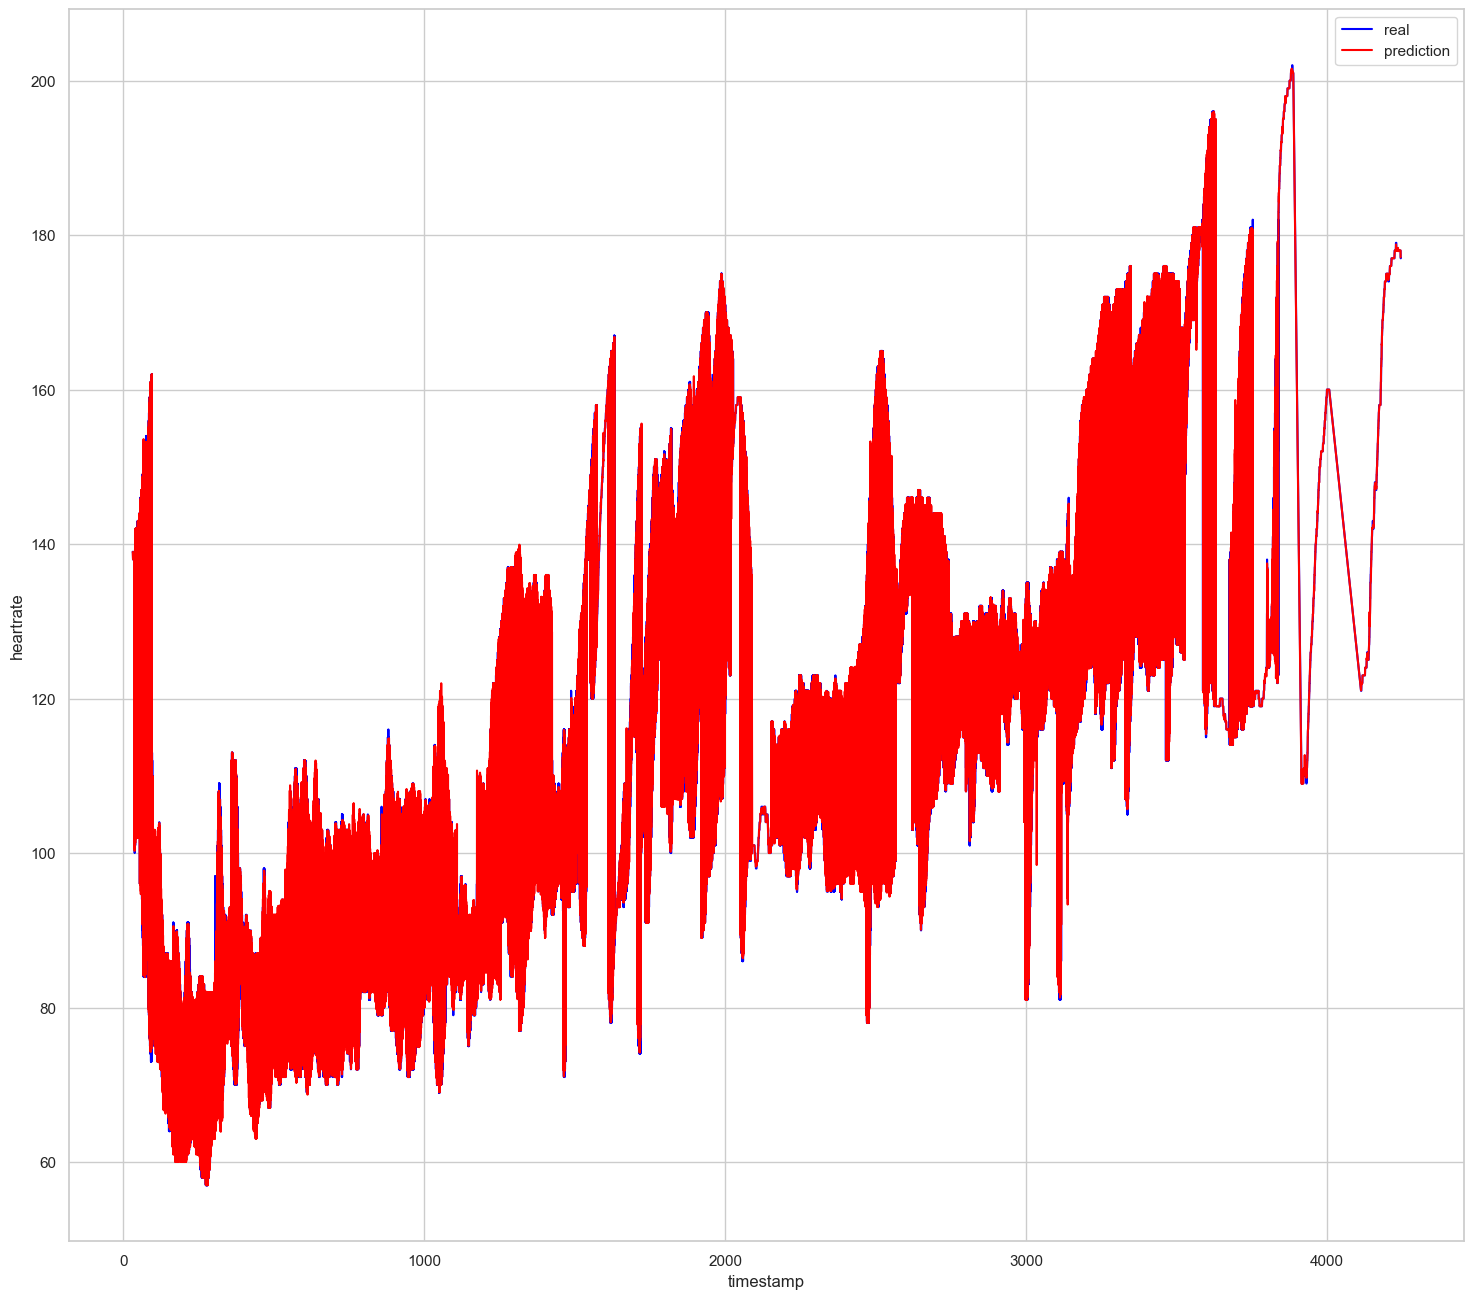

In [274]:
#Graficar los valores registrados
f, ax = plt.subplots(figsize=(18, 16))
sns.lineplot( x = "timestamp", y = "heartrate", data = df_full,ci=None,label='real',color='blue')

#Graficar los valores predecidos
sns.lineplot( x = "time", y = "prediction", data = predictions_data,ci=None,label='prediction',color='red')

# Model to classify activities

## K-means clustering with PCA-reduced data

In [105]:
## Train dataset
pca_model = df_full.drop(["timestamp", "Subject_ID","activityID"],1)[['activity','intensity','heartrate','chestMagne3','handTemperature','chestMagne2','chestAcc16_3','chestAcc6_3','ankleAcc6_1','ankleAcc6_2','ankleAcc6_3']]


X_train = pca_model.drop(['activity','intensity'], axis=1)
y_train = pca_model['intensity'].values

# Test Dataset
X_test = pca_model.drop(['activity','intensity'], axis=1)
y_test = pca_model['intensity'].values

In [106]:
X_train

heartrate  chestMagne3  handTemperature  chestMagne2  chestAcc16_3  \
84305       100.0      42.9228           30.375     -50.7110      -1.68665   
84306       100.0      44.6495           30.375     -50.1898      -1.61331   
84307       100.0      43.1765           30.375     -50.8441      -1.68917   
84308       100.0      43.2943           30.375     -50.2744      -1.57205   
84309       101.0      43.6836           30.375     -51.2222      -1.68503   
...           ...          ...              ...          ...           ...   
259798      162.0      26.4139           25.125     -34.3920      -2.70770   
259799      162.0      26.6907           25.125     -34.1150      -2.47480   
259800      162.0      26.5580           25.125     -34.1578      -2.43342   
259801      162.0      25.0081           25.125     -34.7880      -2.74533   
259802      162.0      24.3045           25.125     -35.1701      -2.35257   

        chestAcc6_3  ankleAcc6_1  ankleAcc6_2  ankleAcc6_3  
84305      -1.53414      9.64677     -1.75240     0.295902  
84306      -1.50369      9.63201     -1.72208     0.356423  
84307      -1.53342      9.58668     -1.75241     0.296221  
84308      -1.41262      9.64714     -1.76741     0.386759  
84309      -1.39866      9.64678     -1.73728     0.295853  
...             ...          ...          ...          ...  
259798     -2.46675      9.44333     -2.13294    -1.639100  
259799     -2.27129      9.35297     -2.25402    -1.683640  
259800     -2.16501      9.38312     -2.10274    -1.669150  
259801     -2.55759      9.44267     -1.99702    -1.806020  
259802     -1.98526      9.38220     -2.26938    -1.880500  

[175498 rows x 9 columns]

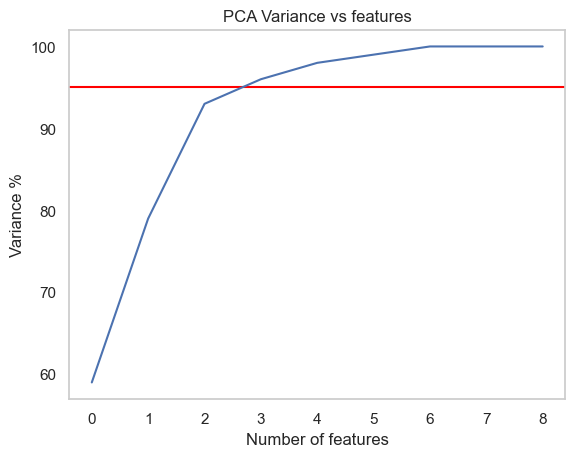

In [107]:
## PCA on provided dataset
from sklearn.decomposition import PCA

pca_pamap2 = PCA()
pca_pamap2.fit(X_train)

feature_var=np.cumsum(np.round(pca_pamap2.explained_variance_ratio_,2)*100)

plt.title("PCA Variance vs features")
plt.ylabel("Variance %")
plt.xlabel("Number of features")
l = plt.axhline(95, color="red")

plt.plot(feature_var)
plt.grid()

In [108]:

## variance expalied for each principal component
My_pca = PCA(n_components=2)
X_train=My_pca.fit_transform(X_train)
print('Explained variation per principal component: {}'.format(My_pca.explained_variance_ratio_))

Explained variation per principal component: [0.59404471 0.19672221]


In [109]:
pc_dataframe=pd.DataFrame(X_train)
activity_df=pd.DataFrame(y_train)

In [110]:
activity_df

0
0        low
1        low
2        low
3        low
4        low
...      ...
175493  high
175494  high
175495  high
175496  high
175497  high

[175498 rows x 1 columns]

In [111]:
pc_dataframe

0          1
0       19.107888  27.795532
1       19.791616  29.409790
2       19.268279  27.959620
3       19.136414  28.240044
4       20.423164  27.831805
...           ...        ...
175493  55.900914  -4.895434
175494  55.898115  -4.610354
175495  55.843631  -4.748593
175496  55.348574  -6.197655
175497  55.002927  -7.017795

[175498 rows x 2 columns]

In [112]:
df_full1=pd.merge(pc_dataframe,activity_df, left_index=True, right_index=True)

In [113]:
df_full1

0_x          1   0_y
0       19.107888  27.795532   low
1       19.791616  29.409790   low
2       19.268279  27.959620   low
3       19.136414  28.240044   low
4       20.423164  27.831805   low
...           ...        ...   ...
175493  55.900914  -4.895434  high
175494  55.898115  -4.610354  high
175495  55.843631  -4.748593  high
175496  55.348574  -6.197655  high
175497  55.002927  -7.017795  high

[175498 rows x 3 columns]

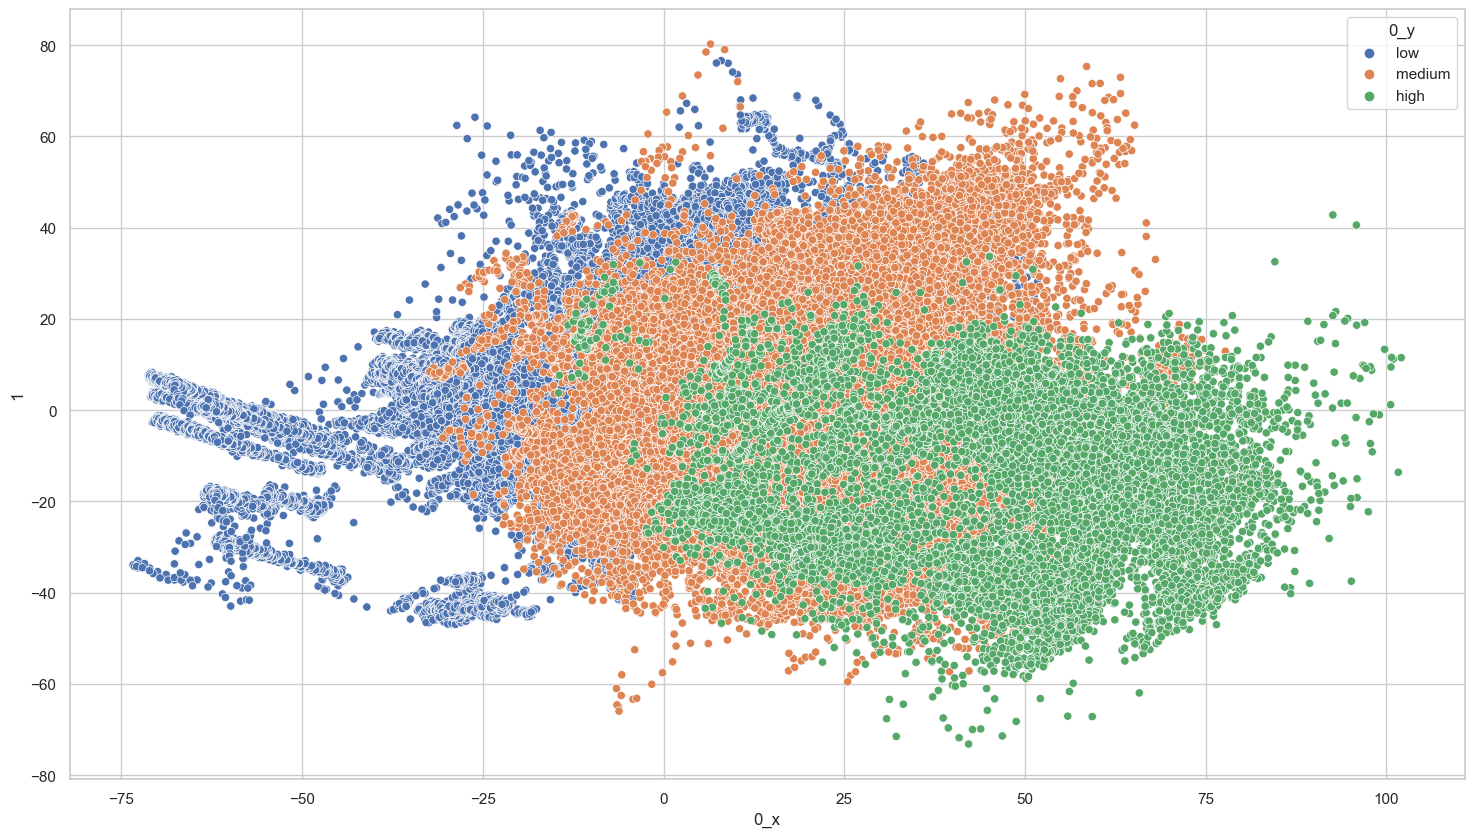

In [130]:


fig,axs = plt.subplots(ncols=1, figsize=(18,10))
sns.scatterplot( x = '0_x', y = 1, data = df_full1,ci=None,color='red',hue='0_y')

plt.show()

In [116]:
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN

kmeans = KMeans(n_clusters=3 ,random_state=10)
kmeans.fit(df_full1[['0_x',1]])
clusters = kmeans.predict(df_full1[['0_x',1]])

centers_pulsars = kmeans.cluster_centers_

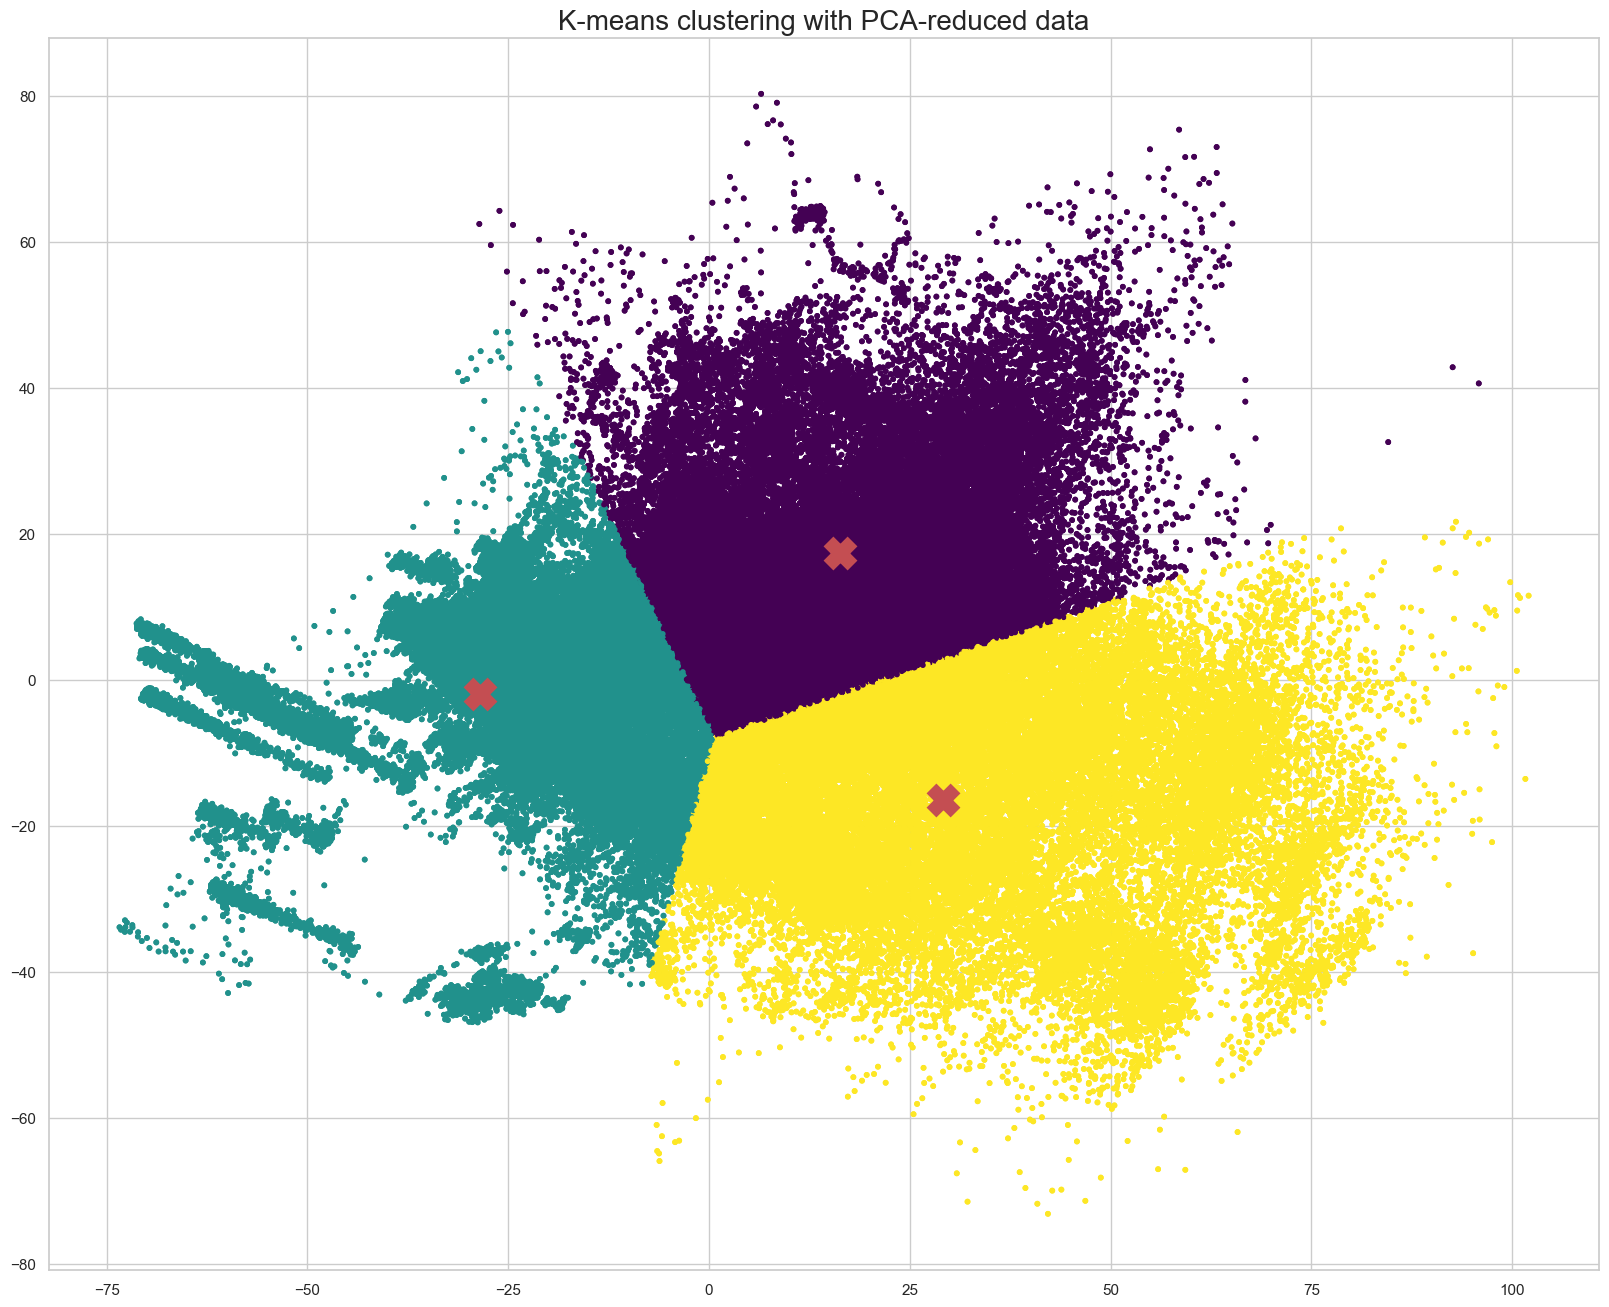

In [117]:
def plot_clusters(X, clusters=None, centers=None):
    plt.scatter(X[:, 0], X[:, 1], c=clusters, s=10, cmap="viridis")
    
    if np.any(centers):
        plt.scatter(
            centers[:, 0], centers[:, 1], marker="x", s=300, linewidths=10, color="r"
        )


X_plot = np.array(df_full1[['0_x',1]])

plt.figure(figsize=[20, 16])
plot_clusters(X_plot, clusters=clusters, centers=centers_pulsars)
plt.title("K-means clustering with PCA-reduced data", fontsize=20)

plot_clusters(X_plot, clusters=clusters, centers=centers_pulsars)

In [118]:
#KMEANS CON PCA y TODAS LAS VARIABLES
kmeans.fit(df_full1[['0_x',1]])
clusters_con_pca=pd.DataFrame(kmeans.labels_, columns=['Class_kmeans_con_pca'])

finalDf = pd.concat([df_full1[['0_x',1]],activity_df], axis = 1)
finalDf = pd.concat([finalDf,clusters_con_pca], axis = 1)
#finalDf = pd.concat([finalDf,clusters_sin_pca], axis = 1)
#finalDf = pd.concat([finalDf,clusters_sin_pca_2_var], axis = 1)

from sklearn.metrics import v_measure_score 

print('Metricas Kmeans con PCA y todas las caracteristicas')
# Calcular la homogeneity y el completeness.
homogeneity = metrics.homogeneity_score(finalDf[0], finalDf['Class_kmeans_con_pca'])
completeness = metrics.completeness_score(finalDf[0], finalDf['Class_kmeans_con_pca'])
v_measure=v_measure_score(finalDf[0], finalDf['Class_kmeans_con_pca'])
print('homogeneity',float(homogeneity))
print('completeness',float(completeness))
print('v_measure',float(v_measure))

Metricas Kmeans con PCA y todas las caracteristicas
homogeneity 0.38667474206274405
completeness 0.3248037143200765
v_measure 0.35304903846072205


## Classification model with decision trees

In [52]:
activityIDdict = {0: 'transient', 1:'lying', 2:'sitting', 3:'standing',
              4:'walking', 5:'running', 6:'cycling', 7:'Nordic walking',
              9:'watching TV', 10:'computer work', 11:'car driving',
              12:'ascending stairs', 13:'descending stairs', 16:'vacuum cleaning',
              17:'ironing', 18:'folding laundry', 19:'house cleaning',
              20:'playing soccer', 24:'rope jumping'}

protocol_acts = [1,2,3,4,5,6,7,17,16,24,12,13]


In [53]:
#Using a seed to facilitate replication of results
dev_data_df = df_full.sample(frac=0.7, random_state=1)
test_data_df = df_full.drop(dev_data_df.index)

In [54]:
from sklearn import tree
tclf = tree.DecisionTreeClassifier()

In [55]:
from sklearn.tree import DecisionTreeClassifier

features_used = ['handAcc16_1', 'handAcc16_2', 'handAcc16_3', 'handAcc6_1', 'handAcc6_2', 'handAcc6_3',
                'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3', 'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3',
                'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3', 'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3',
                'handGyro1', 'handGyro2', 'handGyro3',
                'chestGyro1', 'chestGyro2', 'chestGyro3',
                'ankleGyro1', 'ankleGyro2', 'ankleGyro3','activityID']

train_dt = dev_data_df.loc[:,features_used]
test_dt =  test_data_df.loc[:, features_used]


# getting X,y values for train and test set

X_train_dt = train_dt.drop('activityID', axis=1).values
y_train_dt = train_dt['activityID'].values

X_test_dt = test_dt.drop('activityID', axis=1).values
y_test_dt = test_dt['activityID'].values

In [56]:
tclf = DecisionTreeClassifier()
tclf.fit(X_train_dt,y_train_dt)

DecisionTreeClassifier()

In [57]:
def plot_confusion_matrix(model,X_test,y_test,title='',is_ml=False, labels={}):
    
  ticks = list(map(lambda x : activityIDdict[x], np.unique(y_test).tolist())) if labels=={} else labels.values()
  preds = model.predict(X_test)
  pred_cat = preds if is_ml else np.argmax(preds,axis=1)
  print('model accuracy on test set is: {0:.2f}%'.format(accuracy_score(y_test,pred_cat)*100))
  plt.figure(figsize=(15,8),dpi=120)
  sns.heatmap(confusion_matrix(y_test,pred_cat),cmap='Blues',annot=True, fmt='d',xticklabels=ticks,yticklabels=ticks)
  plt.xlabel('Prediction')
  plt.ylabel('True label')
  plt.title(title)
  plt.show()

model accuracy on test set is: 91.75%


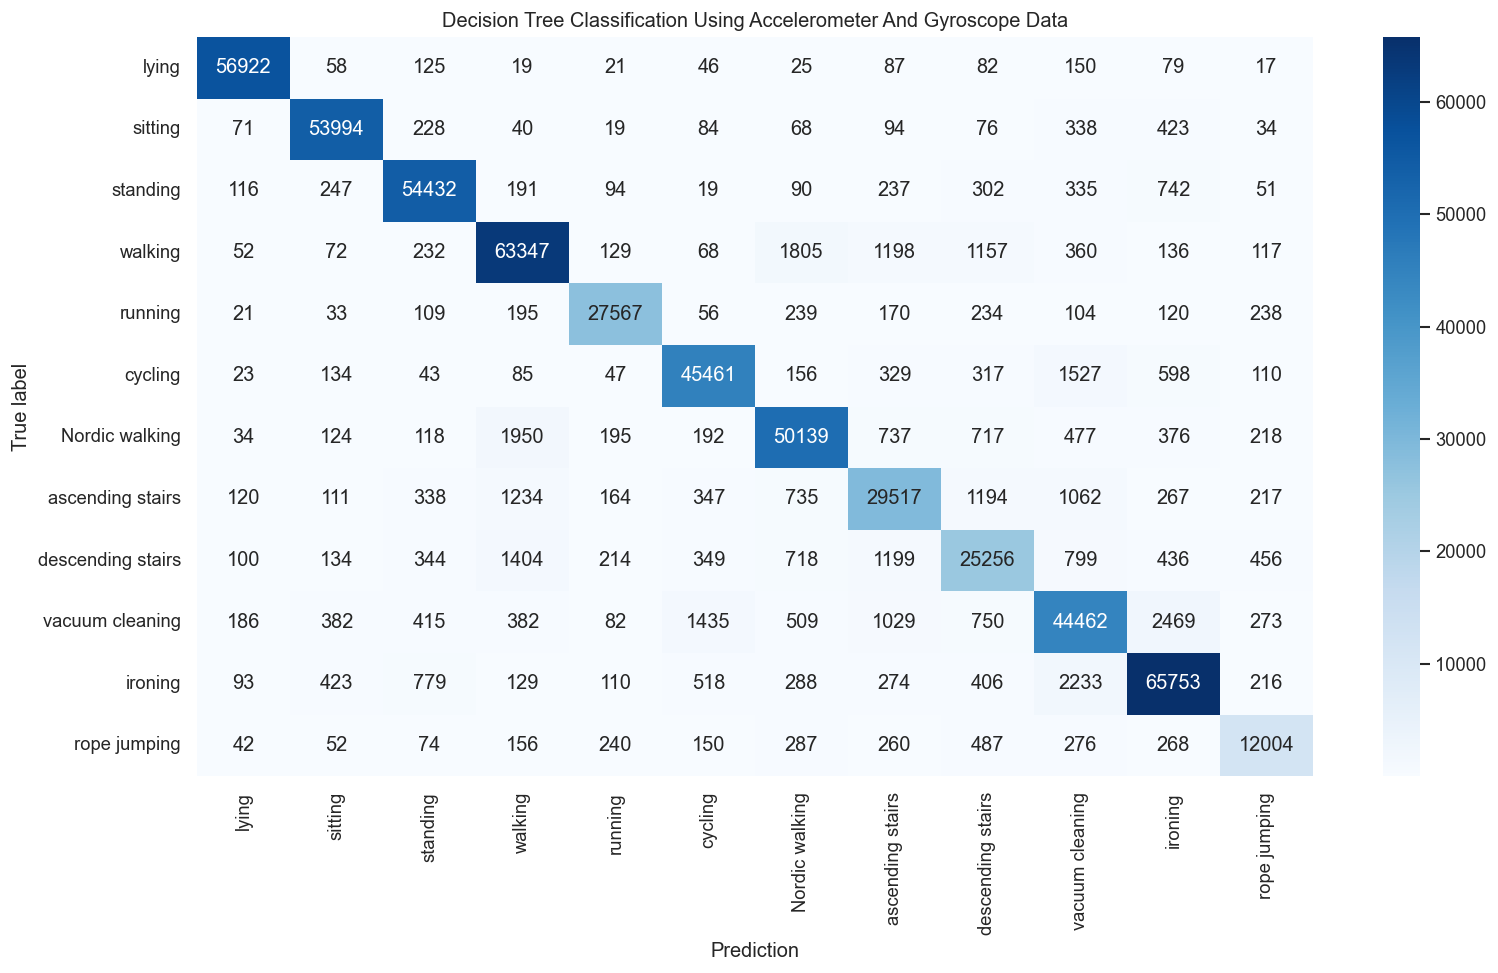

In [58]:
from sklearn.metrics import confusion_matrix,accuracy_score

plot_confusion_matrix(tclf,X_test_dt,y_test_dt,"Decision Tree Classification Using Accelerometer And Gyroscope Data",is_ml=True)